In [36]:
'''
Author:        James Parkington
Created Date:  7/29/2023
Modified Date: 7/29/2023

Any imports that are shared across cells can be imported through this initial cell. I've also introduced some 
runtime configuration parameters to define attributes of each chart once, so that they're treated as defaults 
for each subsequent plot.
'''

import numpy               as np
import pandas              as pd
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gs
import matplotlib.patches  as pch

from adjustText import adjust_text
from cycler     import cycler
from datetime   import datetime as dtt
from typing     import *

colors = sns.color_palette('Set2')
plot_params = {
    # Axes parameters                            # Tick parameters
    'axes.facecolor'     : 'black',              'xtick.labelsize'    : 8,
    'axes.grid'          : False,                'xtick.color'        : 'white',
    'axes.labelcolor'    : 'white',              'xtick.major.size'   : 0,
    'axes.spines.left'   : False,                'ytick.labelsize'    : 8,
    'axes.spines.right'  : False,                'ytick.color'        : 'white',
    'axes.spines.top'    : False,                'ytick.major.size'   : 0,
    'axes.labelsize'     : 10,
    'axes.labelweight'   : 'bold',               # Color cycles
    'axes.titlesize'     : 12,                   'axes.prop_cycle'    : cycler(color = colors),
    'axes.titleweight'   : 'bold',               'image.cmap'         : 'Set2',
    'axes.labelpad'      : 15,                   'legend.borderpad'   : 0.75,       

    # Grid parameters                            # Figure parameters
    'grid.linestyle'     : ':',                  'figure.facecolor'   : 'black',
    'grid.color'         : '0.5',                'figure.figsize'     : (15, 10),
                                                 'figure.autolayout'  : True,

    # Font and text parameters                   # Color cycles  
    'font.family'        : 'DejaVu Sans Mono',   'legend.facecolor'   : '0.3',
    'font.size'          : 8,                    'legend.edgecolor'   : '0.3',
    'font.style'         : 'normal',             'legend.borderpad'   : 0.75, 
    'text.color'         : 'white',              'legend.framealpha'  : '0.5'}

plt.rcParams.update(plot_params)

#### Done
1. What is the busiest month of the year for bike rentals? Can this information guide marketing and staffing decisions?
2. What are the busiest and slowest days of the week for bike rentals? Could this information guide staffing or promotional events?
3. What are the top 5 busiest hours for bike rentals for each season? Could this information guide staffing decisions?
4. Were there any days where the expected pattern of rentals across weekday and hour did not hold?
5. Are there specific hours of the day that see a sharp increase or decrease in bike rentals across different weather situations?
6. During which hours do casual users tend to rent more bikes compared to registered users?
7. Do registered users show different rental patterns compared to casual users across seasons?
8. How does the distribution of bike rentals differ between casual and registered users across different weather conditions?
9. How does the number of bike rentals change from month to month for registered users versus casual users?
10. Do bike rentals increase on holidays due to an increase in casual users or registered users?
11. How does temperature correlate with the number of bike rentals? How could this information be used for demand forecasting?
12. How does the combination of humidity and wind speed affect bike rentals across different seasons?

#### In Progress  
2.  How does a working day versus a non-working day impact bike rentals across different seasons? Could this information guide staffing and inventory management?
3.  How does bike rental behavior change between 2011 and 2012? Can we attribute this to specific factors in the dataset?
4.  Can we predict the number of bike rentals for a given hour based on the weather situation, temperature, humidity, and wind speed?
5.  How does humidity impact the number of rentals? Could this information be used to inform renters or guide marketing strategies?
6.  How does wind speed correlate with bike rentals? Do windy conditions discourage rentals?
7.  Are there any other correlations within the numeric columns in the dataset we might be overlooking?
8.  Given the trend from 2011 and 2012, how many bike rentals should be expected for 2013?

Need more questions--try to make them all linear algebra related with predictive quality.

In [2]:
def load_bike_sharing_data() -> pd.DataFrame:   
    '''
    Loads the Bike Sharing Dataset from the UCI Machine Learning Repository.

    The dataset represents two years (2011 and 2012) of the hourly count of rental bikes from the Capital 
    Bikeshare system in Washington D.C., USA. The counts are categorized as casual, registered, or total, with 
    additional information about the specific hour, weather conditions, and more.

    The dataset beings with the following fields:
    - instant     (int)   : Record index
    - dteday      (str)   : Date
    - season      (int)   : Season (1: spring, 2: summer, 3: autumn, 4: winter)
    - yr          (int)   : Year (0: 2011, 1: 2012)
    - mnth        (int)   : Month (1 to 12)
    - hr          (int)   : Hour (0 to 23)
    - holiday     (int)   : Whether the day is a holiday or not
    - weekday     (int)   : Day of the week
    - workingday  (int)   : 1 if the day is neither a weekend nor holiday, otherwise 0
    - weathersit  (int)   : Weather conditions (1: clear, 2: mist/cloudy, 3: light snow/rain, 4: heavy rain/snow/fog)
    - temp        (float) : Normalized temperature in Celsius (values divided by 41)
    - atemp       (float) : Normalized feeling temperature in Celsius (values divided by 50)
    - hum         (float) : Normalized humidity (values divided by 100)
    - windspeed   (float) : Normalized wind speed (values divided by 67)
    - casual      (int)   : Count of casual users
    - registered  (int)   : Count of registered users
    - cnt         (int)   : Count of total rental bikes including both casual and registered

    These fields are added immediately following to avoid repeating transformations:
    - ordinal     (int)   : Ordinal representation of the date

    After loading the dataset, we'll conduct an exploratory data analysis to uncover the underlying patterns 
    and relationships in the data. This will include a variety of techniques such as data visualization, 
    aggregation, and correlation analysis.

    Note: I learned while carrying out the exercise that the included `season` column is misleading and not
          useful in the context of the other datetime fields. For example, it considers Jan, Feb, and Mar to be
          "Spring", which is innacurate, so I've curated a new `season` field with the helper function `get_season()`.

          Also, all 1/0 (int) fields above are converted to booleans.

    Returns:
        pd.DataFrame: The Bike Sharing dataset as a pandas DataFrame.
    '''

    def get_season(date: pd.Timestamp) -> int:
        '''
        Seasons are defined as:
            Spring: from March 21 to June 20
            Summer: from June 21 to September 22
            Autumn: from September 23 to December 20
            Winter: from December 21 to March 20

        Parameters:
            date (datetime) : Timestamp object

        Returns:
            int : season of the date (1: Spring, 2: Summer, 3: Autumn, 4: Winter)
        '''

        day_of_year = date.timetuple().tm_yday

        if   day_of_year in range(80,  172): return 1  # Spring
        elif day_of_year in range(172, 265): return 2  # Summer
        elif day_of_year in range(265, 355): return 3  # Autumn
        else:                                return 4  # Winter

    df = pd.read_csv("./Data/hour.csv")
    df['dteday']     = pd.to_datetime(df['dteday'])
    df['season']     = df['dteday'].apply(get_season)
    df['holiday']    = df['holiday'].astype(bool)
    df['workingday'] = df['workingday'].astype(bool)
    df['ordinal']    = df['dteday'].apply(lambda x: x.toordinal())

    return df

bike_sharing = load_bike_sharing_data()
bike_sharing

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,ordinal
0,1,2011-01-01,4,0,1,0,False,6,False,1,0.24,0.2879,0.81,0.0000,3,13,16,734138
1,2,2011-01-01,4,0,1,1,False,6,False,1,0.22,0.2727,0.80,0.0000,8,32,40,734138
2,3,2011-01-01,4,0,1,2,False,6,False,1,0.22,0.2727,0.80,0.0000,5,27,32,734138
3,4,2011-01-01,4,0,1,3,False,6,False,1,0.24,0.2879,0.75,0.0000,3,10,13,734138
4,5,2011-01-01,4,0,1,4,False,6,False,1,0.24,0.2879,0.75,0.0000,0,1,1,734138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,4,1,12,19,False,1,True,2,0.26,0.2576,0.60,0.1642,11,108,119,734868
17375,17376,2012-12-31,4,1,12,20,False,1,True,2,0.26,0.2576,0.60,0.1642,8,81,89,734868
17376,17377,2012-12-31,4,1,12,21,False,1,True,1,0.26,0.2576,0.60,0.1642,7,83,90,734868
17377,17378,2012-12-31,4,1,12,22,False,1,True,1,0.26,0.2727,0.56,0.1343,13,48,61,734868


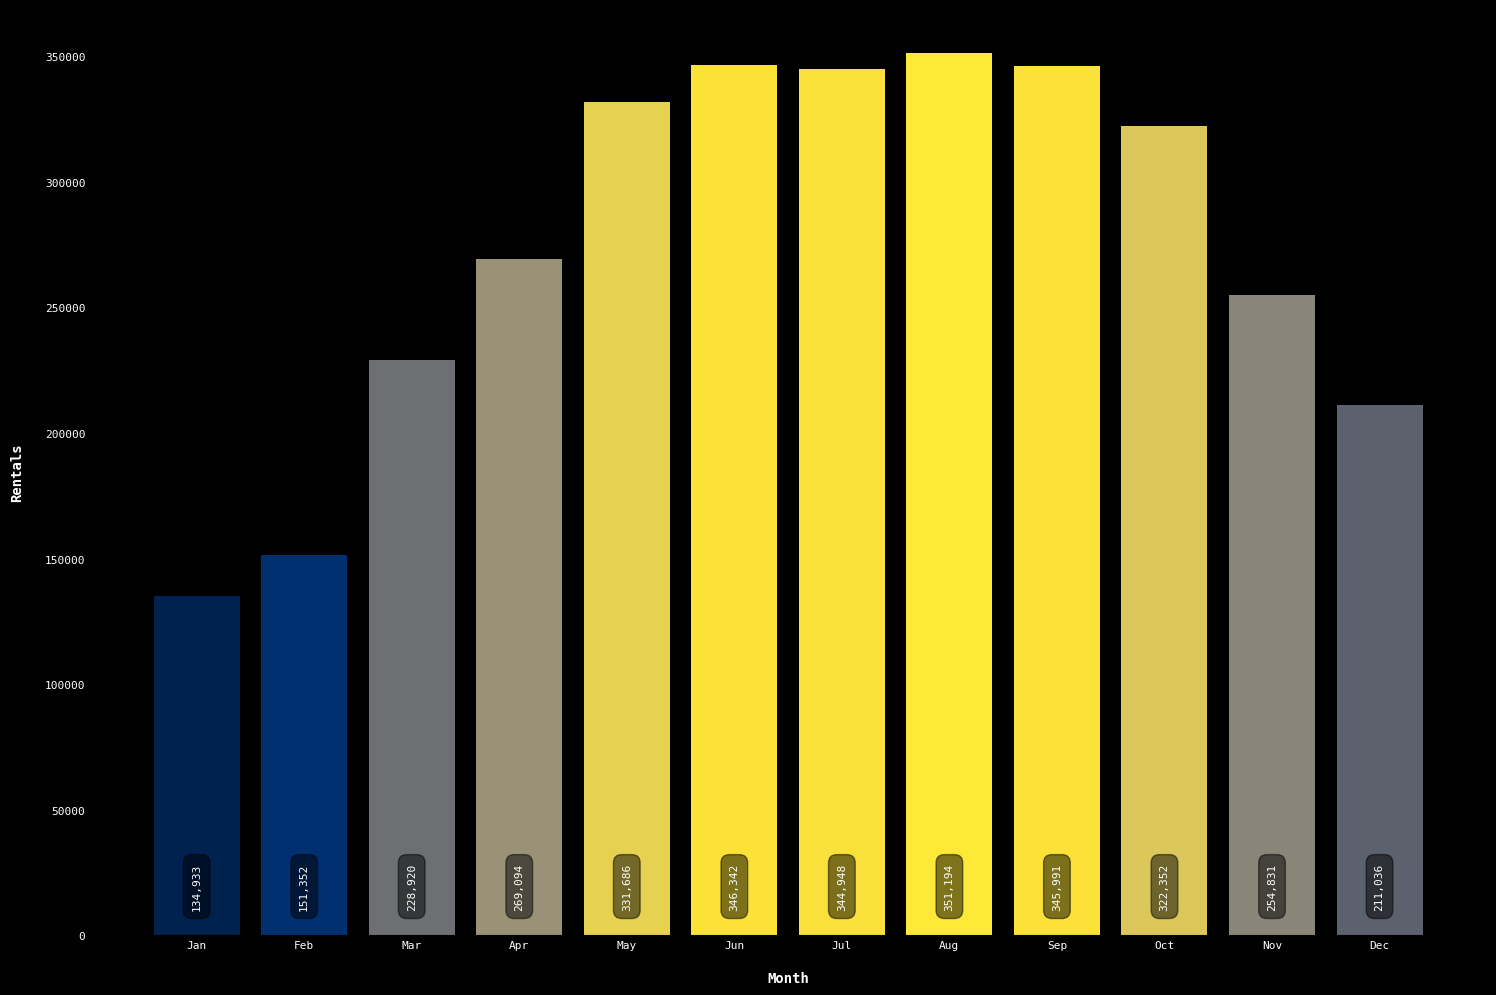

In [3]:
# 1. What is the busiest month of the year for bike rentals?

def busiest_month(df : pd.DataFrame) -> str:
    '''
    Finds and visualizes the busiest month of the year for bike rentals with a heatmap-like color scheme.
    
    This function groups the data by month and sums the total counts of bike rentals for each month.
    The result is visualized using a bar plot with a heatmap-like color palette, where the color intensity
    corresponds to the number of rentals, providing a visually compelling representation of the busiest months.

    Parameters:
        df (pd.DataFrame) : The bike sharing dataset as a pandas DataFrame.
    
    Insights drawn from this analysis could be valuable for making informed decisions regarding marketing campaigns, 
    staffing, inventory management, etc. For instance, during the busiest month, bike-sharing companies might want 
    to increase their marketing efforts to maximize profit, ensure they have sufficient staff to handle the increased 
    demand, and make sure they have enough bikes in inventory to meet customer needs.
    '''

    month_counts = df.groupby('mnth')['cnt'].sum()
    norm         = plt.Normalize(month_counts.min(), month_counts.max())
    
    bars = plt.bar(x      = month_counts.index, 
                   height = month_counts.values, 
                   color  = plt.cm.cividis(norm(month_counts.values)))
    
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, 10000, f'{int(bar.get_height()):,}',
                 va = 'bottom', ha = 'center', rotation = 90,
                 bbox = dict(facecolor = '0', alpha = 0.5, boxstyle = 'round, pad = 0.75'))
    
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.xlabel('Month')
    plt.ylabel('Rentals')

busiest_month(bike_sharing)

### <span style="color:#0693e3">**Analysis for Question 1**</span>

The results above indicate that the busiest month for bike rentals is August, with a total of **351,194** rentals, closely followed by June and July with **346,342** and **344,948** rentals respectively. The dataset has some clear <span style="color:#0693e3">**seasonality**</span>, since the total number of rentals significantly increases starting from March, reaches its peak in August, and then gradually decreases towards the end of the year. This pattern corresponds to the warmer and more pleasant weather conditions during the spring and summer months.

These insights can be extremely valuable for both operational and strategic decision-making in a hypothetical bike rental company:

- <span style="color:#0693e3">**Inventory Management**</span>  
  High demand months like June, July, and August require sufficient inventory to cater to the increased customer base. Preparation for these months should start well in advance to ensure a smooth supply of bikes.
 
- <span style="color:#0693e3">**Staffing**</span>  
  Higher demand implies more customer interactions, which necessitates increased staffing during these months. This could be in the form of customer service representatives, maintenance staff, or even delivery personnel for companies that offer a drop-off and pick-up service.
 
- <span style="color:#0693e3">**Marketing and Promotions**</span>  
  Marketing campaigns and promotional offers can be strategically timed around these high-demand months to attract new customers and encourage existing customers to use the service more frequently. Conversely, targeted campaigns during the off-peak months can help maintain a flow of rentals during these down periods.
  
- <span style="color:#0693e3">**Pricing Strategy**</span>  
  Dynamic pricing strategies can be adopted where prices are slightly increased during high-demand months, or special discounts are provided during off-peak months to encourage rentals.

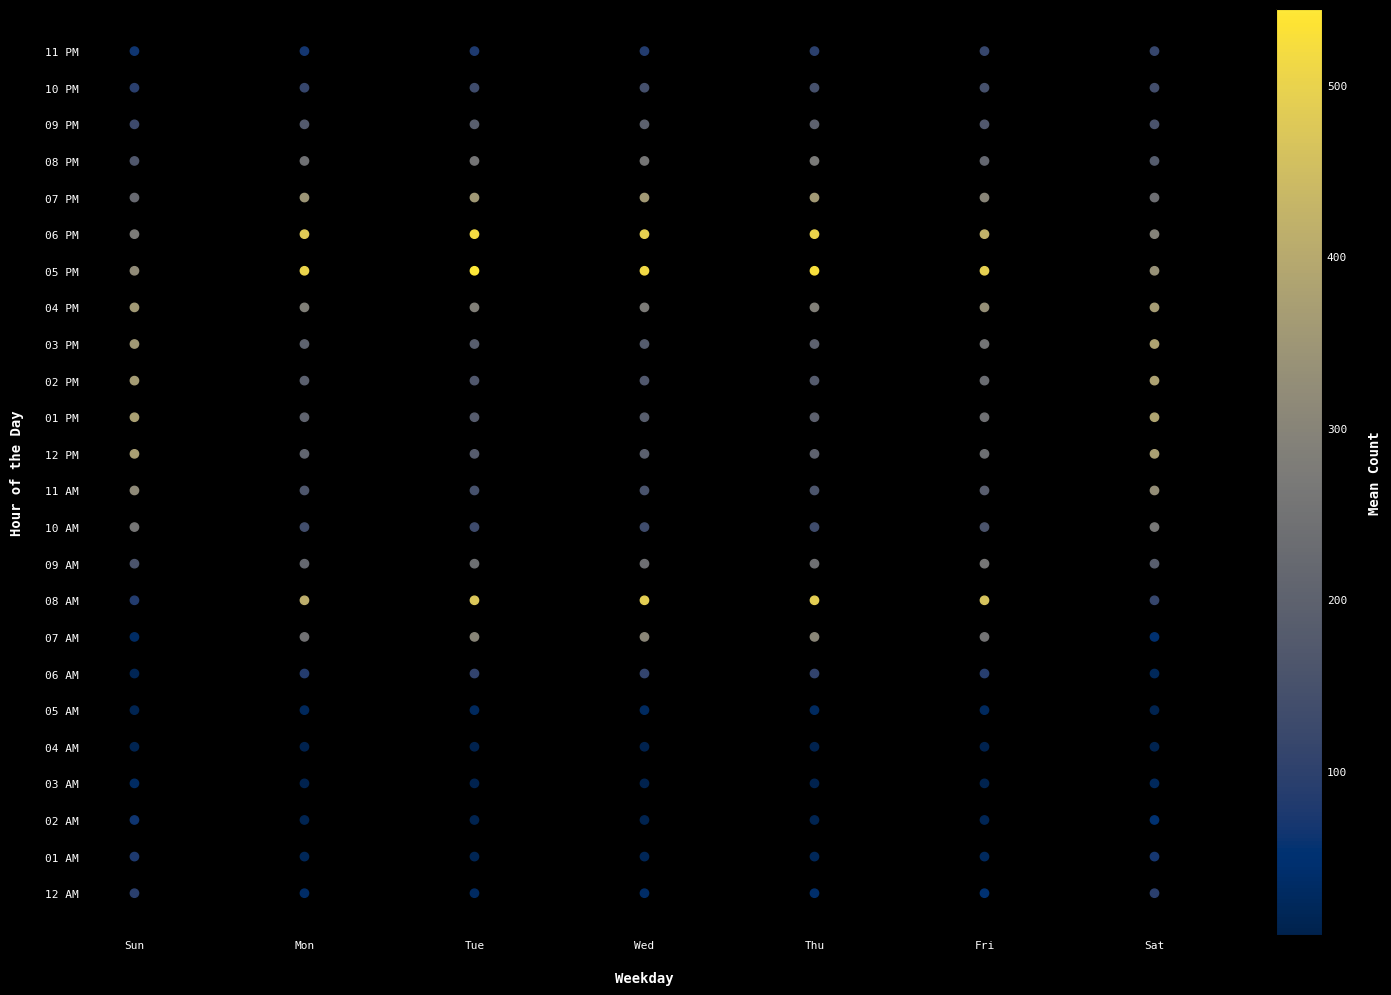

In [4]:
# 2. What are the busiest and slowest weekdays for bike rentals?

def busiest_slowest_weekdays(df : pd.DataFrame):
    '''
    Finds and visualizes the busiest and slowest weekdays for bike rentals with a scatterplot. Each point's size
    and color indicate the mean number of rentals at that specific weekday and hour.
    
    This function adds a `weekday` column to the DataFrame, groups the data by weekday and hour, then calculates 
    the mean number of bike rentals for each weekday-hour combination. The size and color of the points in the 
    scatterplot represent the mean number of rentals, allowing for a clear visualization of the demand for rentals 
    throughout the week.
    
    Parameters:
        df (pd.DataFrame) : The bike sharing dataset as a pandas DataFrame.
    
    The insights from this analysis could be useful in scheduling staff hours and planning promotional events. 
    For instance, staff levels could be increased during busy periods to ensure good customer service, while 
    promotional events could be scheduled during slower periods to boost demand.
    '''

    weekday_hour_counts = df.groupby(['weekday', 'hr'])['cnt'].mean().reset_index()

    plt.scatter(x    = weekday_hour_counts['weekday'], 
                y    = weekday_hour_counts['hr'], 
                c    = weekday_hour_counts['cnt'], 
                cmap = 'cividis')
    
    plt.xticks(range(7),  ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', "Fri", 'Sat'])
    plt.yticks(range(24), [dtt.strptime(str(i), "%H").strftime("%I %p") for i in range(24)])
    plt.xlabel('Weekday')
    plt.ylabel('Hour of the Day')
    plt.colorbar(label = 'Mean Count')

busiest_slowest_weekdays(bike_sharing)

### <span style="color:#0693e3">**Analysis for Question 2**</span>

The scatter plot above provides a detailed view of the average number of bike rentals for every hour of each day of the week. The size and color of each point indicate the mean count of bike rentals, with larger, more red points representing higher counts.

Here are some key observations from the plot:

- <span style="color:#0693e3">**Weekday Patterns**</span>  
  On weekdays (Monday to Friday), the busiest times are around 8 AM and 5 PM, aligning with typical commuting hours. This suggests that a significant portion of the demand during these days comes from commuters.
  
- <span style="color:#0693e3">**Weekend Patterns**</span>  
  On weekends (Saturday and Sunday), demand peaks around 1 PM to 4 PM, indicating a shift towards leisure or non-commute usage.

- <span style="color:#0693e3">**Slowest Times**</span>  
  The slowest times, across all days of the week, are in the early morning hours (from 12 AM to 5 AM), when most people are likely asleep.

Analyzing these bike rental patterns can help a bike-sharing company optimize both operations and promotions. Staffing could be dynamically adjusted based on the expected demand. More personnel could be scheduled for weekday mornings and late afternoons to accommodate commuting riders, while weekend afternoons might need increased staff to handle leisure riders. When the demand is lower, we have an opportunity to boost it with targeted promotional events. For instance, late-night ride events with special discounts could encourage usage during early morning hours. Likewise, marketing campaigns could be tailored to the observed patterns, emphasizing commuting by bike on weekdays and promoting leisurely rides on weekends. Through these strategies, we can effectively cater to the existing customer habits and potentially stimulate new demand.

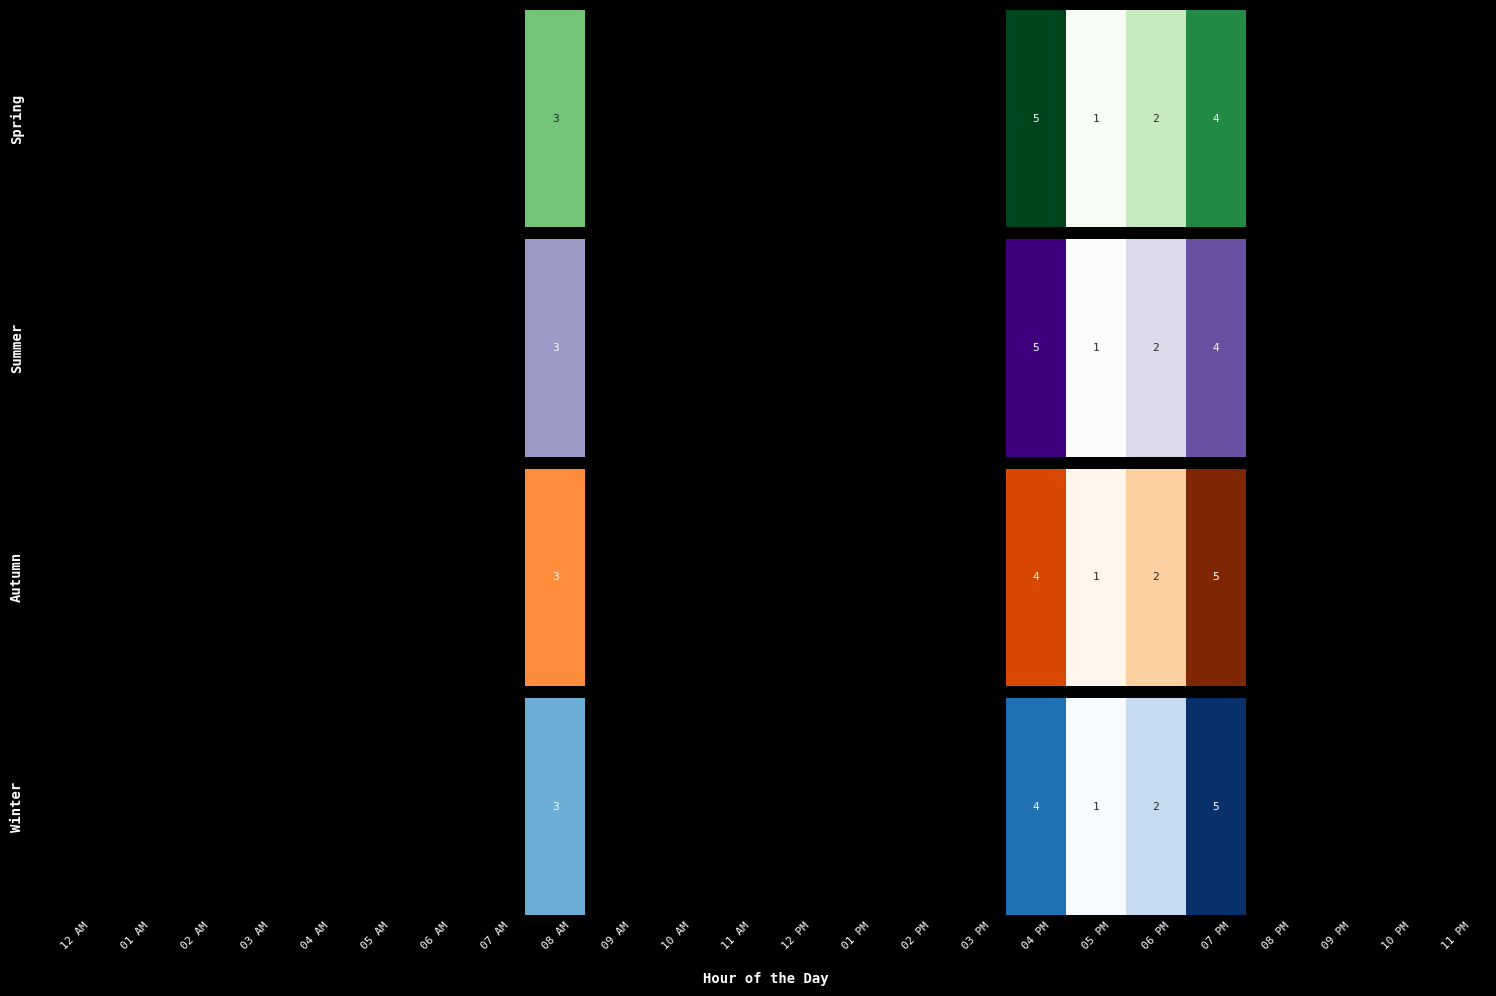

In [5]:
# 3. What are the top 5 busiest hours for bike rentals for each season?

def top_5_hours_each_season(df : pd.DataFrame):
    '''
    Finds and visualizes the top 5 busiest hours for bike rentals for each season using a heatmap. Each cell in 
    the heatmap is colored based on its ranking within each season, with the busiest hour ranked as 1.

    This function creates a pivot table from the input DataFrame, calculating the mean count of bike rentals for each 
    combination of season and hour. That pivot table is then ranked to find the top 5 busiest hours for each season. 
    The function then plots a heatmap subplot for each season with hours on the x-axis. 
    
    The color of each cell in the heatmap corresponds to the rank of the hour within the season, with different color 
    schemes for each season. 

    Parameters:
        df (pd.DataFrame) : The bike sharing dataset as a pandas DataFrame.

    This information could guide staffing decisions by indicating when more staff may be needed to handle 
    increased demand during peak hours in different seasons.
    '''

    heatmap = df.pivot_table(index = 'season', columns = 'hr', values = 'cnt', aggfunc = 'mean') \
                .rank(axis = 1, method = 'min', ascending = False) \
                .where(lambda x: x <= 5)

    _, axs = plt.subplots(4, 1, sharex = True)
    colors = {1: ['Spring', 'Greens'], 
              2: ['Summer', 'Purples'], 
              3: ['Autumn', 'Oranges'], 
              4: ['Winter', 'Blues']}

    for i, ax in enumerate(axs, start = 1):
        sns.heatmap(heatmap.loc[[i]], 
                    cmap  = colors[i][1], 
                    annot = True, 
                    cbar  = False, 
                    ax    = ax) \
           .set(yticks = [], xlabel = '', ylabel = colors[i][0])

    axs[-1].set_xticks(np.arange(0.5, 24.5, 1))
    axs[-1].set_xticklabels([dtt.strptime(str(i), "%H").strftime("%I %p") for i in range(24)], rotation = 45)
    plt.xlabel('Hour of the Day')

top_5_hours_each_season(bike_sharing)

### <span style="color:#0693e3">**Analysis for Question 3**</span>
The heatmap provides us with the top 5 busiest hours for bike rentals during each season, based on mean counts. Regardless of the season, it appears that the demand for bike rentals peaks at two main periods: around 8 AM and between 4 PM to 7 PM. This indicates a pattern that aligns with typical commuting hours.

<span style="color:#0693e3">**Consistent Intraday Demand Across Seasons**</span>  
Despite changes in weather and daylight hours across seasons, the demand for bike rentals during commuting hours remains consistently high. This could indicate that a significant proportion of users are using the bikes for daily commuting, which is not largely affected by seasonal changes. Because of this, a prospective bike-sharing company could allow for routine maintenance work to be scheduled during the less busy hours to cause minimal disruption to the service.

This consistent pattern of demand, regardless of season, provides valuable insight for the bike-sharing company to better staff resources and improve customer service, since year-long patterns are known and invariable in ways that the program's weekday patterns aren't.

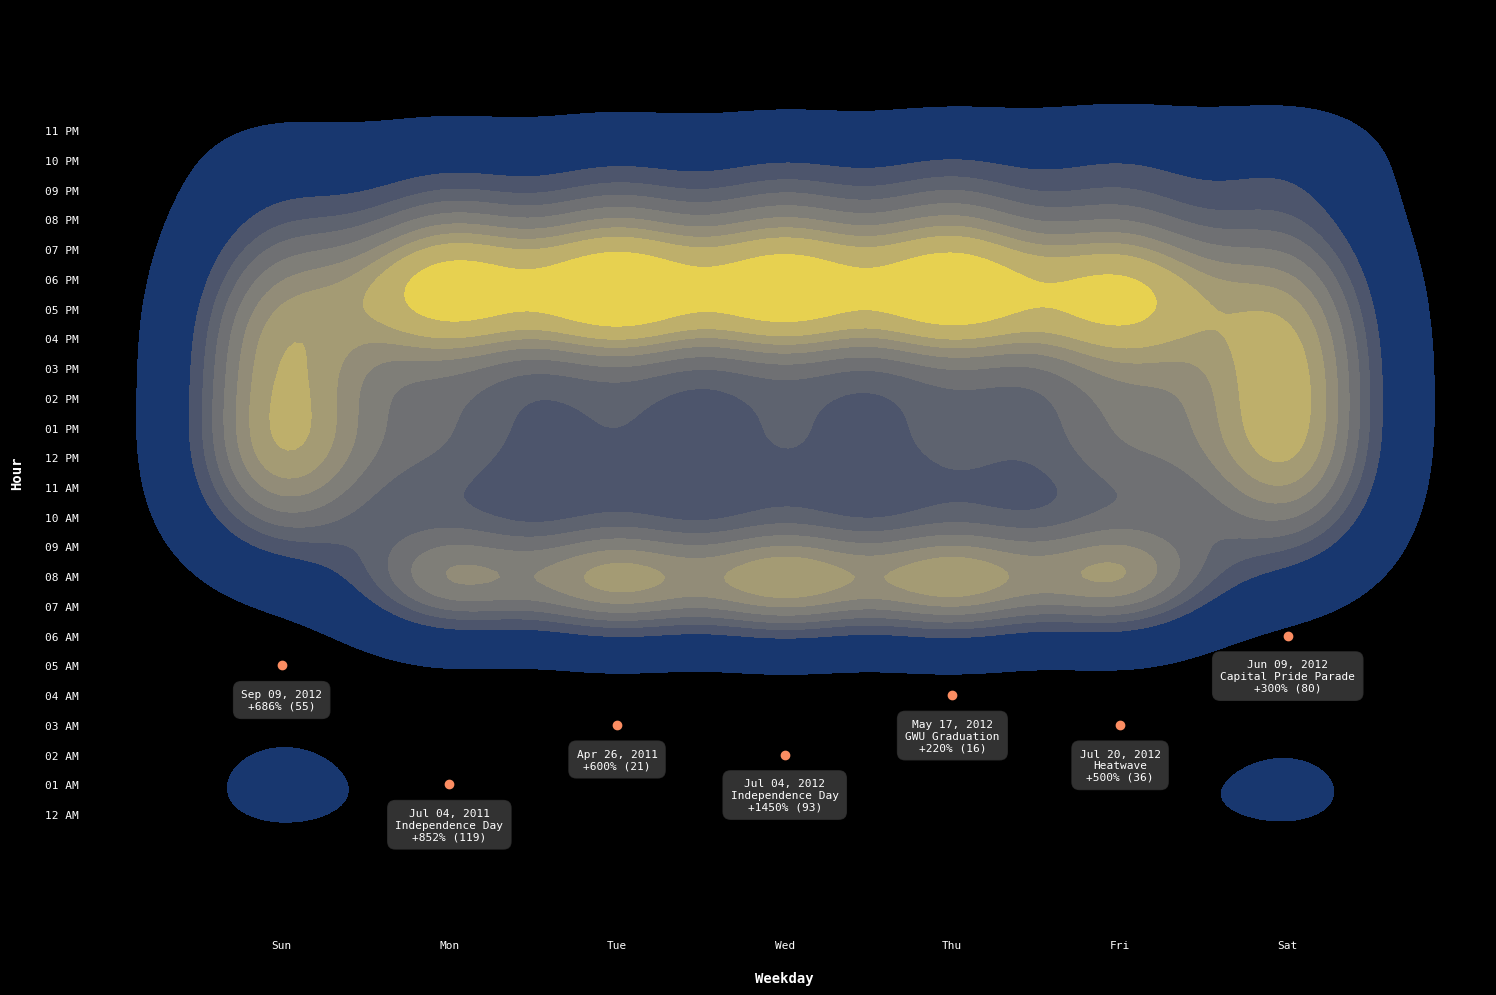

In [6]:
# 4. Were there any anomalous days, in which the expected pattern of rentals across weekday and hour did not hold?

def deviations_from_expected(df : pd.DataFrame):
    '''
    The color of each cell in the heatmap corresponds to the rank of the hour within the season, with different color 
    Analyzes and visualizes the deviations from the expected pattern of bike rentals, grouped by weekday and hour.

    This function primarily performs the following steps:

    1. Calculates the median number of rentals for each unique combination of weekday and hour as 'expected' rentals.
    2. Computes the relative difference between the actual and expected rentals for each data entry.
    3. Identifies the most anomalous day for each weekday (the day with the highest relative difference).
    4. Visualizes the results using a Kernel Density Estimation (KDE) plot, where the anomalies are highlighted.

    The anomalies are marked with a date, associated significant events (if any), and the relative difference in the 
    number of rentals. Significant events are specified manually.

    Parameters:
        df (pd.DataFrame) : The bike sharing dataset as a pandas DataFrame.

    The purpose of this function is to provide insight into when and how often the actual demand significantly deviates 
    from the usual pattern. Such deviations could be caused by a variety of factors such as weather conditions, public 
    events, etc. 
    
    By identifying these anomalies, a prospective bike sharing company could better understand the underlying causes and 
    potentially incorporate them into their demand forecasting models and promotional materials.
    '''
    
    expected_rentals = df.groupby(['weekday', 'hr'])['cnt'].median().rename('median')
    df               = df.merge(expected_rentals, left_on = ['weekday', 'hr'], right_index = True)
    df['diff']       = (df['cnt'] - df['median']) / df['median']
    anomalous_days   = df.loc[df.groupby('weekday')['diff'].idxmax()]
    events           = {0 : None,
                        1 : "Independence Day",
                        2 : None,
                        3 : "Independence Day",
                        4 : "GWU Graduation",
                        5 : "Heatwave",
                        6 : "Capital Pride Parade"}

    sns.kdeplot(x       = df["weekday"], 
                y       = df["hr"], 
                weights = df["cnt"], 
                fill    = True,
                cmap    = 'cividis')
    plt.scatter(anomalous_days['weekday'], 
                anomalous_days['hr'])

    def create_label(row):
        event = events.get(row['weekday'], '')
        line  = f"{event}\n" if event else ""
        return f"{row['dteday'].strftime('%b %d, %Y')}\n{line}{row['diff'] * 100:+.0f}% ({row['cnt']})"

    for (weekday, hr), label in zip(anomalous_days[['weekday', 'hr']].values, anomalous_days.apply(create_label, axis = 1)):
        plt.text(weekday, hr - 0.8, label, ha = 'center', va = 'top', 
                 bbox = dict(facecolor = '1', alpha = 0.2, boxstyle = 'round, pad = 0.75'))

    plt.xticks(range(7),  ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', "Fri", 'Sat'])
    plt.yticks(range(24), [dtt.strptime(str(i), "%H").strftime("%I %p") for i in range(24)])
    plt.xlabel('Weekday')
    plt.ylabel('Hour')

deviations_from_expected(bike_sharing)

### <span style="color:#0693e3">**Analysis for Question 4**</span>
This chart examines 7 anomalous data points, representing bike rentals significantly different from the expected trend on a certain day and hour.

- <span style="color:#0693e3">**2012-09-09, Hour 5**</span> (Sunday): A total of **55** rentals were observed, which is a 685% increase from the typical 7 rentals at this hour on Sundays. No specific event is known to have occurred on this day, but it's possible that a local or minor event not listed in the dataset influenced these numbers.
  
- <span style="color:#0693e3">**2011-07-04, Hour 1**</span> (Monday): There were **119** rentals recorded, marking an 852% increase from the typical median of 12.5 rentals at this hour on Mondays. This date is significant because it's Independence Day in the United States, which likely caused the spike in bike rentals.
  
- <span style="color:#0693e3">**2011-04-26, Hour 3**</span> (Tuesday): There were **21** rentals, a 600% increase over the typical 3 rentals at this hour on Tuesdays. No specific event correlates with this anomaly.
  
- <span style="color:#0693e3">**2012-07-04, Hour 2**</span> (Wednesday): **93** rentals were found, representing a 1,450% increase from the usual 6 rentals at this hour on Wednesdays. As with the previous case, this date represents Independence Day, explaining the increased bike usage.
  
- <span style="color:#0693e3">**2012-05-17, Hour 4**</span> (Thursday): On this day, **16** rentals were observed, a 220% increase from the typical 5 rentals at this hour on Thursdays. This anomaly corresponds with George Washington University's graduation day, possibly leading to increased bike rentals.
  
- <span style="color:#0693e3">**2012-07-20, Hour 3**</span> (Friday): The data showed **36** rentals, a 500% increase from the typical 6 rentals at this hour on Fridays. This date aligns with a recorded heatwave, which may have influenced people to rent bikes rather than walk or use other forms of transport.
  
- <span style="color:#0693e3">**2012-06-09, Hour 6**</span> (Saturday): **80** rentals were registered, a 300% increase from the usual 20 rentals at this hour on Saturdays. This anomaly corresponds with the Capital Pride Parade, a major event that could have led to the increase in bike rentals.  
  <br>

<span style="color:#0693e3">**Business Takeaways**</span>

1. **Event Tracking**: Monitoring and leveraging local and national events, like parades or holidays, could boost bike rentals. This might mean increased marketing leading up to the event or partnering with event organizers.

2. **Weather Sensitivity**: Weather conditions like heatwaves can impact bike usage. Offering weather-based promotions or preparing for higher demand during certain weather conditions could be beneficial.

3. **Academic Calendar**: University events such as graduation ceremonies can influence bike rental numbers. Establishing partnerships with local universities and offering student discounts or special offers during these times could attract more users.

4. **Exploring Unknown Factors**: Some anomalies are not linked to identifiable events, suggesting other factors are at play. This could be a valuable area for further research and understanding, which could uncover additional opportunities to increase bike rentals.

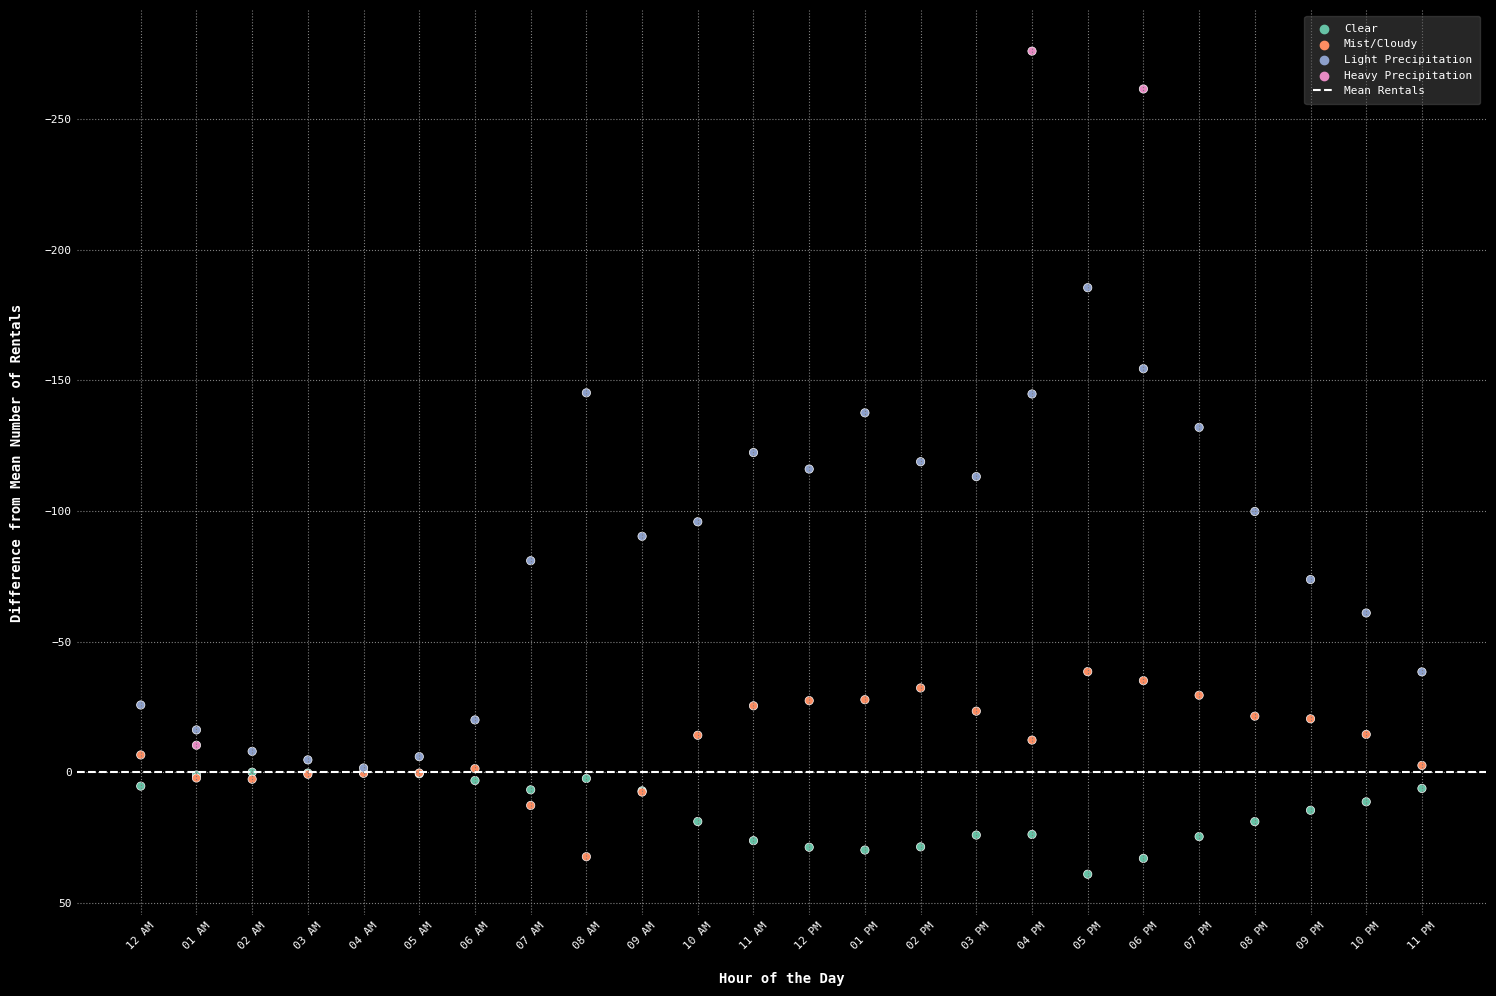

In [7]:
# 5. Are there specific hours of the day that see a sharp increase or decrease in bike rentals across different weather situations?

def hourly_rentals_by_weathersit(df : pd.DataFrame):
    '''
    Visualizes the average difference from the mean number of bike rentals across different hours and weather situations.

    1. Calculates the mean number of rentals for each unique hour.
    2. For each weather situation and hour, calculates the mean number of rentals and then the difference from the mean 
       number of rentals.
    3. Creates a scatter plot where the x-axis represents the hour and the y-axis represents the difference from the mean 
       number of bike rentals, and each point is colored based on the weather situation.
    4. Visualizes a line at y = 0, representing the mean number of rentals.

    Parameters:
        df (pd.DataFrame) : The bike sharing dataset as a pandas DataFrame.

    The purpose of this function is to provide insights into how the time of day and weather situations affect the 
    demand for bike rentals, relative to the mean demand. Understanding these patterns can help a prospective bike sharing 
    company anticipate sudden surges or drops in demand and manage their resources accordingly.
    '''

    weather = {1 : 'Clear', 
               2 : 'Mist/Cloudy', 
               3 : 'Light Precipitation', 
               4 : 'Heavy Precipitation'}

    mean_rentals     = df.groupby('hr')['cnt'].mean()
    weathersit_means = df.groupby(['hr', 'weathersit'])['cnt'].mean().reset_index()
    weathersit_means['weathersit_label'] = weathersit_means['weathersit'].map(weather)
    weathersit_means['diff_from_mean'] = weathersit_means.apply(lambda row: row['cnt'] - mean_rentals[row['hr']], axis = 1)

    sns.scatterplot(x       = 'hr', 
                    y       = 'diff_from_mean', 
                    hue     = 'weathersit_label', 
                    data    = weathersit_means)

    plt.axhline(0, color = '1', linestyle = 'dashed', label = 'Mean Rentals')
    plt.xticks(range(24), [dtt.strptime(str(i), "%H").strftime("%I %p") for i in range(24)], rotation = 45)
    plt.gca().invert_yaxis()
    plt.xlabel('Hour of the Day')
    plt.ylabel('Difference from Mean Number of Rentals')
    plt.grid(True)
    plt.legend()

hourly_rentals_by_weathersit(bike_sharing)

### <span style="color:#0693e3">**Analysis for Question 5**</span>
This analysis provides insights into bike rental demand under different weather conditions, across all hours of the day. Four weather situations have been recorded and plotted—**Clear**, **Mist/Cloudy**, **Light Precipitation**, and **Heavy Precipitation**—across 24 hours of the day.

<span style="color:#0693e3">**Weather Impact**</span>  
The weather conditions have a clear impact on the number of bike rentals. For all hours of the day, the mean count of rentals is the highest when the weather is clear, followed by mistry or cloudy conditions. Light precipitation causes a further decrease in the rental counts, and heavy precipitation seems to lower the demand substantially for the few bikes that were rented in those conditions.

<span style="color:#0693e3">**Patterns & Observations**</span>  
While the mean count of bike rentals is naturally affected by the weather conditions, the demand pattern across the hours remains similar irrespective of the weather situation. The commuting hours maintain their status as peak demand hours, even though the actual demand decreases with worsening weather.

This pattern suggests that while the weather has an impact on the level of demand, it does not significantly alter the hours of peak demand. This could indicate that commuters are a major part of the user base, and their need to travel during specific hours is less influenced by weather conditions. That said, one of the most precipitous drops can be see at 5 PM when light rain is present. It seems users leaving work and seeing rain and generally more discouraged from renting a bike.

<span style="color:#0693e3">**Implications for Bike Rental Service**</span>  
Recognizing that demand is sensitive to weather conditions, the service could consider weather-based dynamic management. For instance, during forecasted periods of heavy precipitation, the service could ensure additional provisions are made for protecting the bikes or even explore collaborations with other modes of public transport.

Lastly, given the strong demand during commuting hours, irrespective of weather, the service could consider promoting season passes or commuter-specific discount packages to attract regular users and incentivize off-peak use.

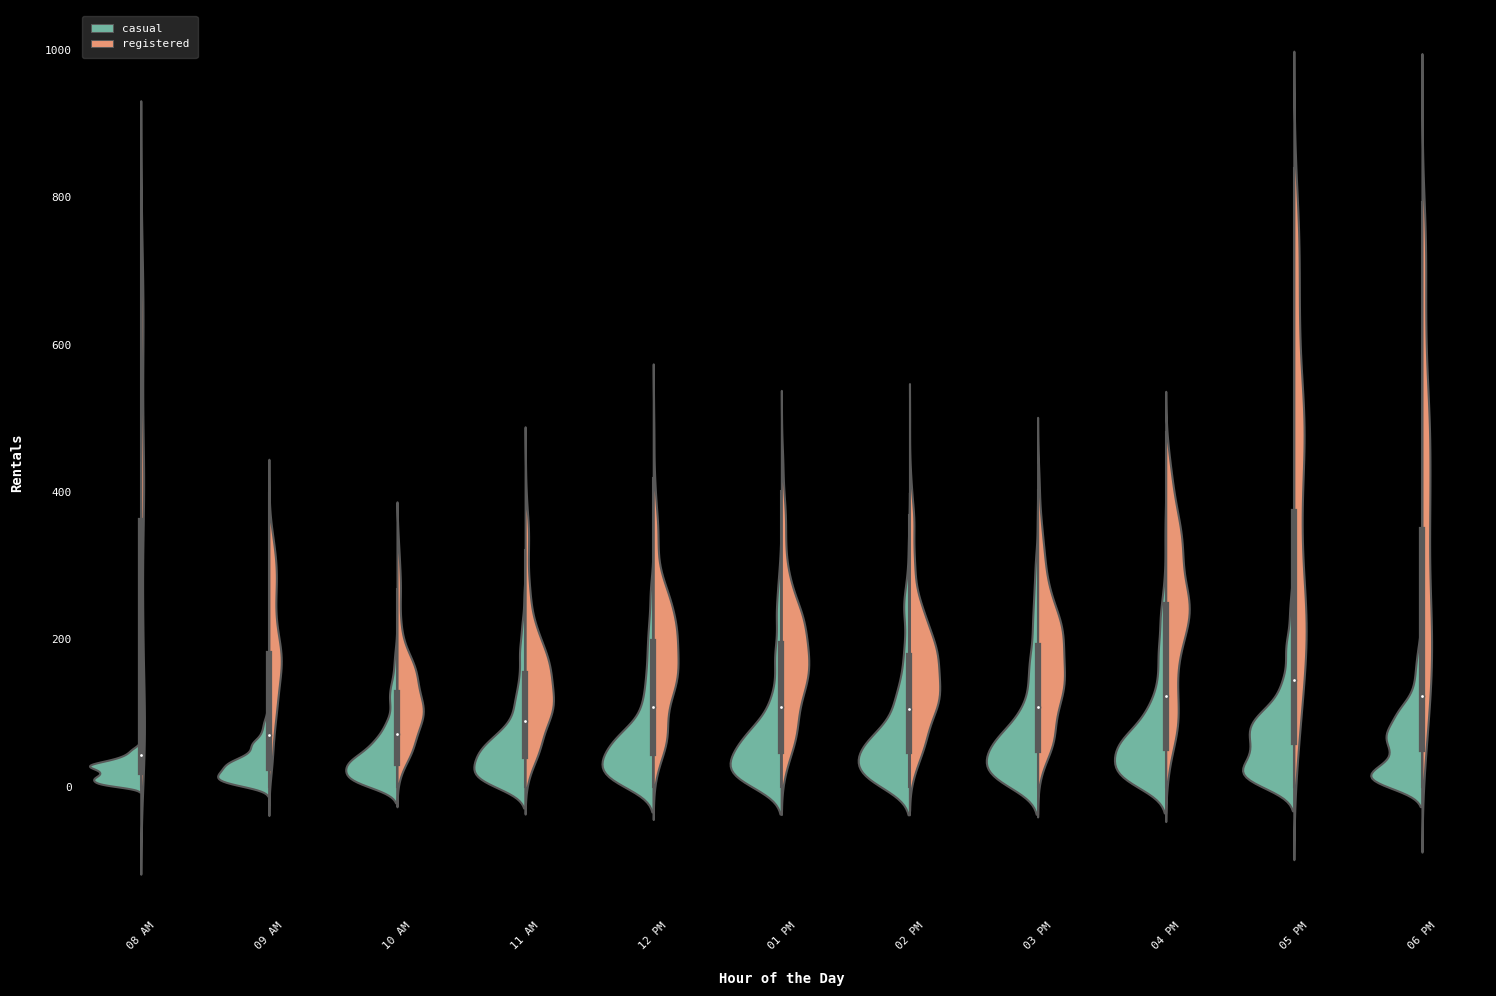

In [8]:
# 6. During which hours do casual users tend to rent more bikes compared to registered users?

def hourly_rentals_by_usertype(df : pd.DataFrame):
    '''
    Visualizes the distribution of bike rentals for casual and registered users across different hours.

    1. Melts the dataframe to have `hr`, `type`, and `n` (total rentals) columns.
    2. Creates a violin plot where the x-axis represents the hour and the y-axis represents the number of bike 
       rentals, and the distributions are separated based on the user type.

    Parameters:
        df (pd.DataFrame) : The bike sharing dataset as a pandas DataFrame.

    The purpose of this function is to provide insights into how the time of day affects the demand for bike rentals for 
    casual and registered users. Understanding these patterns can help a prospective bike sharing company optimize their 
    service offerings for different user groups.
    '''

    df_filtered = df[df['hr'].between(8, 18)]
    sns.violinplot(x     = 'hr', 
                   y     = 'Rentals', 
                   hue   = 'type', 
                   split = True,
                   data  = df_filtered.melt(id_vars    = 'hr', 
                                            value_vars = ['casual', 'registered'], 
                                            var_name   = 'type', 
                                            value_name = 'Rentals'))

    plt.xticks(range(11), [dtt.strptime(str(i), "%H").strftime("%I %p") for i in range(8, 19)], rotation=45)
    plt.xlabel('Hour of the Day')
    plt.legend(loc = 'upper left')

hourly_rentals_by_usertype(bike_sharing)

### <span style="color:#0693e3">**Analysis for Question 6**</span>
This analysis dives into the rental patterns of casual and registered users from 8 AM to 6 PM, shedding light on their distinct usage behaviors and preferences.

<span style="color:#0693e3">**User Type Impact**</span>  
Registered users typically rent more bikes throughout the day, but particularly so during commuting hours. Notably, there is a strong peak of rentals by registered users at 8 AM and again at 5 PM, reflecting a pattern of commuting to and from work or school. On the other hand, casual users tend to rent more bikes in the afternoon hours, likely for leisure activities, museum-hopping, or other non-commute travels.

<span style="color:#0693e3">**Patterns & Observations**</span>  
This pattern suggests that registered users are likely local commuters, while casual users might be tourists, day-trippers, or locals on leisurely outings. The biggest differences between casual and registered rentals occur at 10 AM and 3 PM, where casual rentals are the highest relative to registered rentals.

<span style="color:#0693e3">**Implications for Bike Rental Service**</span>  
Recognizing these distinct usage patterns, the bike rental service can develop user-specific marketing strategies. For registered users, the service could offer discounted commuting passes or tiered pricing models based on usage to ensure that they continue to use the service for their daily commuting needs. Timely availability of bikes and fast, reliable service would be crucial for this user group.

For casual users, who likely use the service for leisure, the bike rental service could offer afternoon passes or create combined passes that include popular tourist attractions. Offering guides or recommended routes for sightseeing could also be an added value to this group. Furthermore, by highlighting benefits of registration such as cost-effectiveness for regular use, priority access during peak hours, and personalized route recommendations, casual users might be encouraged to register and use the service more regularly.

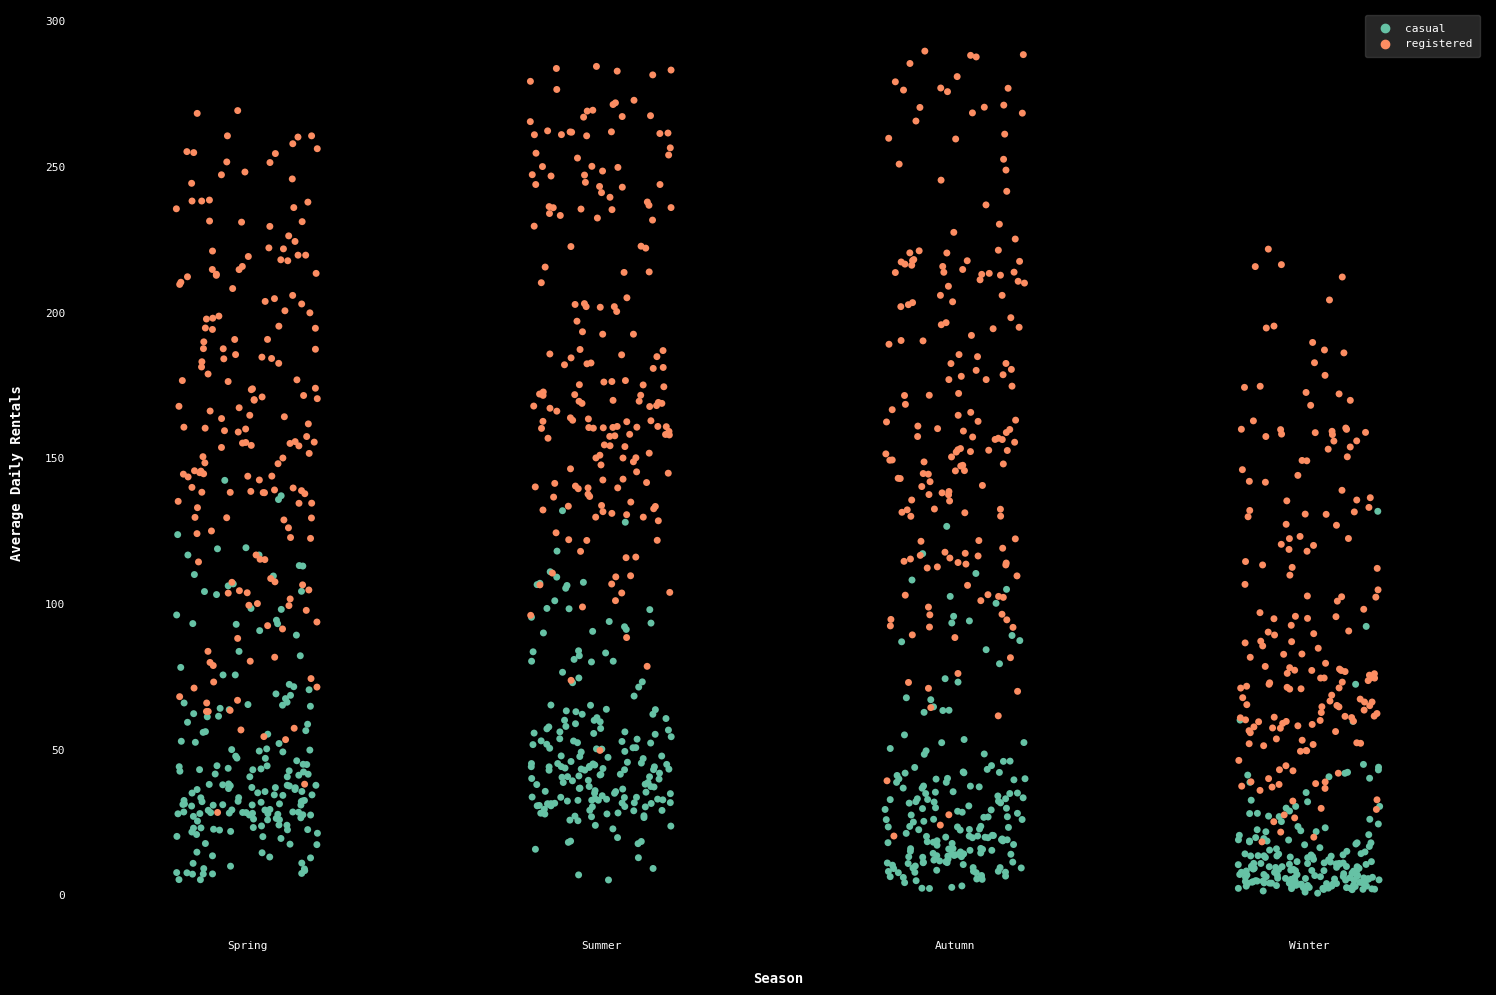

In [48]:
# 7. Do registered users show different rental patterns compared to casual users across seasons?

def seasonal_daily_average_rentals(df : pd.DataFrame):
    '''
    Visualizes the daily average number of bike rentals for casual and registered users across different seasons.

    1. Maps the `season` column to corresponding season names.
    2. Groups the data by `season` and `dteday` and melts the `casual` and `registered` columns.
    3. Creates a strip plot where the x-axis represents the season and the y-axis represents the daily average number of bike rentals,
       and the points are colored based on the user type.

    Parameters:
        df (pd.DataFrame) : The bike sharing dataset as a pandas DataFrame.

    The purpose of this function is to provide insights into how the seasons affect the demand for bike rentals for casual and 
    registered users. Understanding these patterns can help a prospective bike sharing company optimize their service offerings for 
    different user groups. A jitter is introduced to allow anomalies to be detected across both categories.
    '''

    grouped = df.groupby(['season', 'dteday'])[['casual', 'registered']].mean().reset_index()
    sns.stripplot(x      = 'season', 
                  y      = 'Average Daily Rentals', 
                  hue    = 'type', 
                  jitter = 0.2,
                  data   = grouped.melt(id_vars    = ['season', 'dteday'], 
                                        value_vars = ['casual', 'registered'], 
                                        var_name   = 'type', 
                                        value_name = 'Average Daily Rentals'))

    plt.xticks(range(4), ['Spring', 'Summer', 'Autumn', 'Winter'])
    plt.xlabel('Season')
    plt.legend()

seasonal_daily_average_rentals(bike_sharing)

### <span style="color:#0693e3">**Analysis for Question 7**</span>
This analysis investigates how different seasons impact the average daily bike rentals for casual and registered users, uncovering distinctive rental behaviors in varying seasonal conditions.

<span style="color:#0693e3">**Seasonal Impact**</span>  
Both casual and registered users display changing bike rental patterns across the seasons. However, the trends are not uniform for the two user types. For casual users, the bike rental demand is highest in the spring (**46.17** average rentals) and summer (**50.03** average rentals), which are generally considered favorable seasons for outdoor activities. In contrast, registered users rent bikes more frequently in the summer (**184.85** average rentals) and autumn (**168.38** average rentals), potentially suggesting that these users continue their commute routines regardless of the less pleasant weather in autumn. 

<span style="color:#0693e3">**Patterns & Observations**</span>  
Interestingly, while the mean bike rentals for registered users are consistently higher than casual users across all seasons, the difference is much more pronounced in winter. This could reflect the fact that casual users, who likely use the service for leisure, are more deterred by cold, inclement weather than registered users who might be using the bikes for necessary commute. 

<span style="color:#0693e3">**Implications for Bike Rental Service**</span>  
Understanding these seasonal usage patterns can aid the bike rental service in optimizing their offerings. For casual users, the company can focus on marketing campaigns during the spring and summer months, offering special seasonal passes or organizing outdoor events that could attract more users. For registered users, who appear to be less influenced by the change of seasons, maintaining a reliable service during less favorable weather conditions becomes critical. The service could consider introducing weatherproof accessories or offering incentives for bike rentals during off-peak seasons.

Further, these findings suggest the possibility of leveraging the warmer seasons to convert casual users to registered ones, which adds more insight to our previous suggestion on conversion for casual users in <span style="color:#0693e3">**Question 6**</span>.

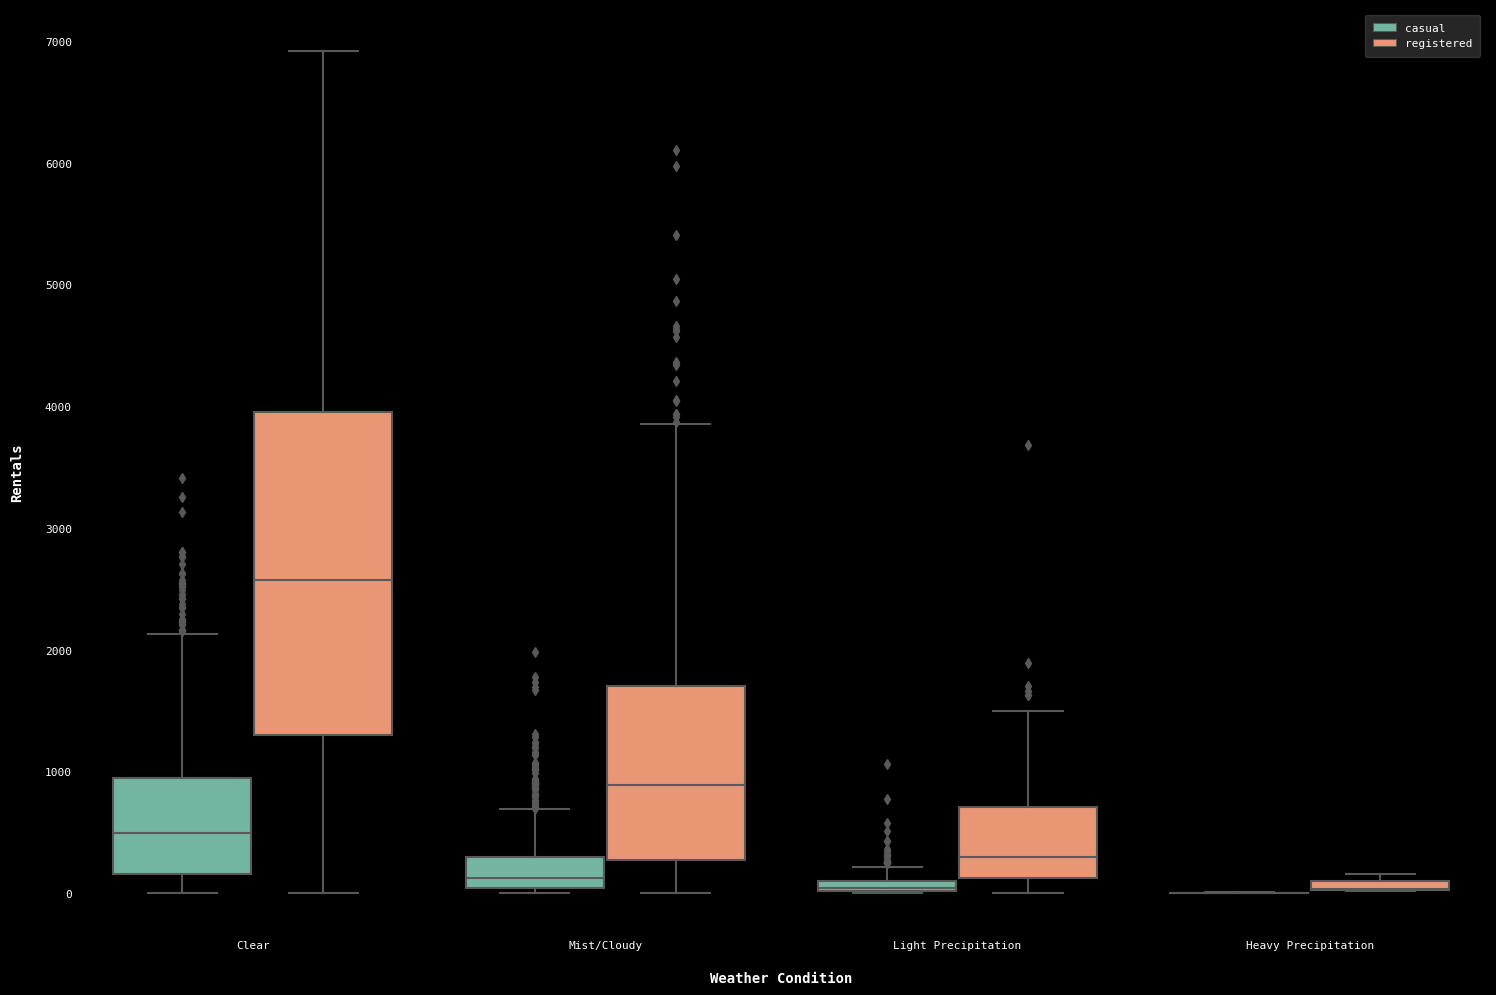

In [10]:
# 8. How does the distribution of bike rentals differ between casual and registered users across different weather conditions?

def rentals_per_weather_condition(df: pd.DataFrame):
    '''
    Visualizes the distribution of bike rentals for casual and registered users across different weather conditions.

    1. Maps the `weathersit` column to corresponding weather conditions.
    2. Groups the data by `season` and `dteday` and melts the `casual` and `registered` columns.
    3. Creates a violin plot where the x-axis represents the weather condition and the y-axis represents the daily average 
       number of bike rentals,
       and the points are colored based on the user type.

    Parameters:
        df (pd.DataFrame) : The bike sharing dataset as a pandas DataFrame.

    The purpose of this function is to provide insights into how different weather conditions affect the demand for bike
    rentals for casual and registered users. Understanding these patterns can help a prospective bike sharing company optimize 
    their service offerings for different user groups under varying weather conditions.
    '''

    weather = {1 : 'Clear', 
               2 : 'Mist/Cloudy', 
               3 : 'Light Precipitation', 
               4 : 'Heavy Precipitation'}

    grouped = df.groupby(['weathersit', 'dteday'])[['casual', 'registered']].sum().reset_index()
    sns.boxplot(x    = 'weathersit', 
                y    = 'Rentals', 
                hue  = 'type', 
                data = grouped.melt(id_vars    = ['weathersit', 'dteday'], 
                                    value_vars = ['casual', 'registered'], 
                                    var_name   = 'type', 
                                    value_name = 'Rentals'))

    plt.xticks(range(4), weather.values())
    plt.xlabel('Weather Condition')
    plt.legend()

rentals_per_weather_condition(bike_sharing)

### <span style="color:#0693e3">**Analysis for Question 8**</span>
The analysis aims to understand the distribution of bike rentals among casual and registered users under varying weather conditions, uncovering some insightful patterns and behaviors.

<span style="color:#0693e3">**Impact of Weather Conditions**</span>  
As expected, weather conditions significantly affect bike rentals. Clear weather conditions facilitate the highest average bike rentals for both casual and registered users, with **661.06** and **2679.18** rentals on average, respectively. In contrast, during heavy rain or snow, the average rentals drastically drop to just **2.67** for casual users and **71.67** for registered users. 

<span style="color:#0693e3">**Patterns & Observations**</span>  
Even under less favorable conditions like light rain or snow, registered users appear more likely to rent bikes compared to casual users. The average rentals under these conditions are **451.83** for registered users and a mere **75.94** for casual users. This pattern reiterates our previous findings that registered users, who might rely on the service for regular commuting, are less deterred by adverse weather.

<span style="color:#0693e3">**Implications for Bike Rental Service**</span>  
The varying rental patterns based on weather conditions provide valuable insights for a prospective bike rental service. On clear days, which see high rentals from both user groups, the company can ensure they have a sufficient number of bikes available. On days with adverse weather, when casual users are less likely to rent, the service can focus more on the needs of registered users, perhaps ensuring the stock remains full at locations where registered users tend to start their journeys.

Furthermore, the service could consider offering weather protection gear or discounts on such days to incentivize usage. For registered users, the company could implement a notification system alerting them about upcoming bad weather and reminding them about available accessories or alternatives. For casual users, weather-based dynamic pricing can be explored, providing discounts or special offers during less favorable weather conditions, encouraging them to continue using the service.

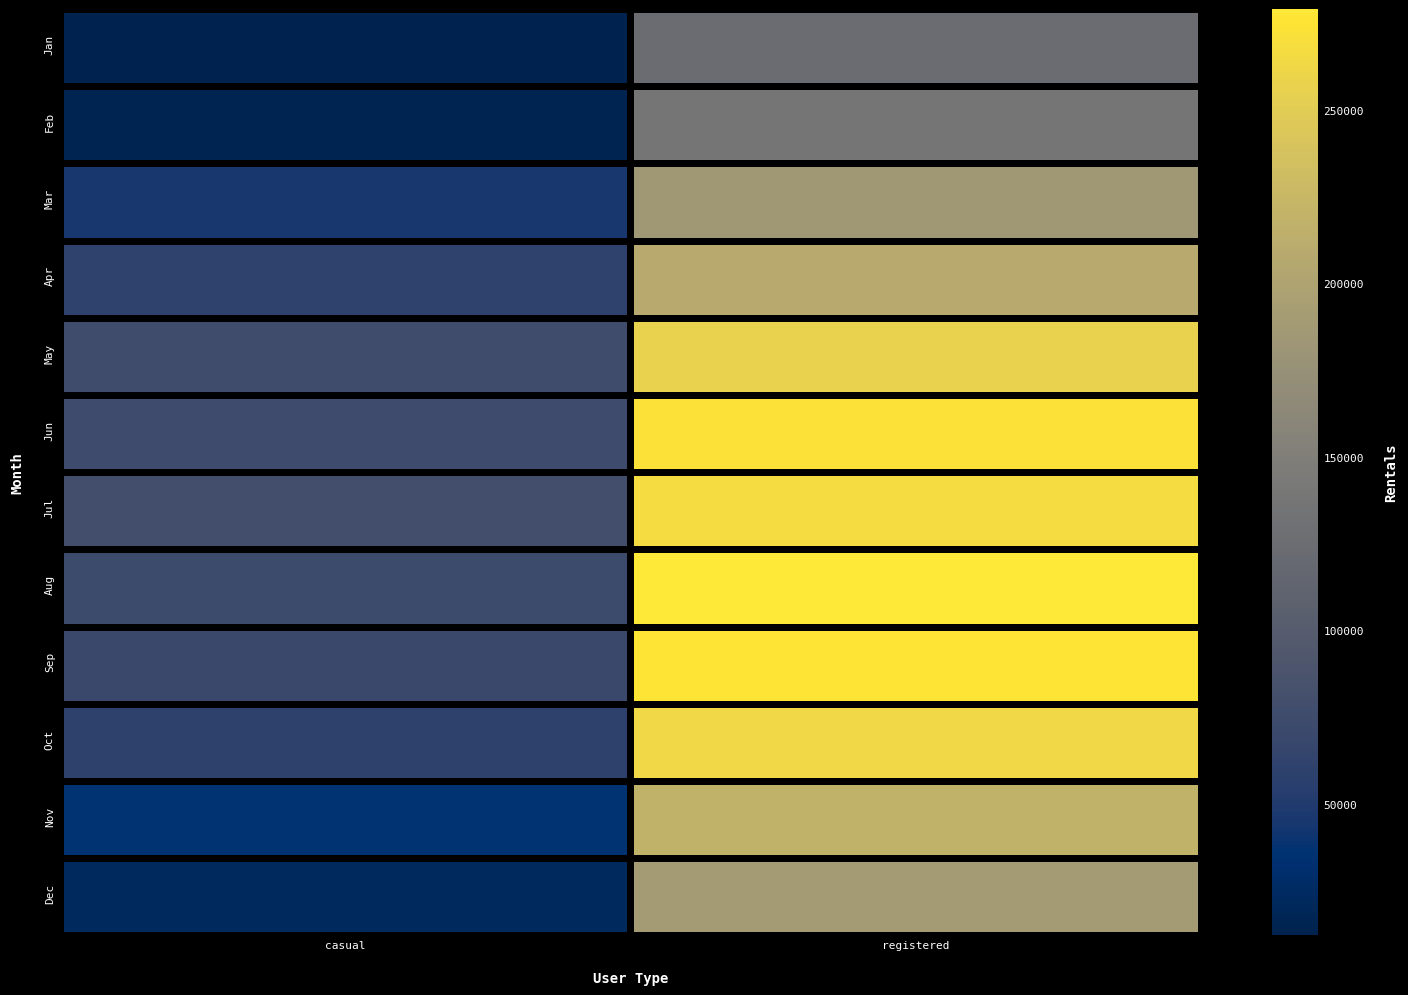

In [11]:
# 9. How does the number of bike rentals change from month to month for registered users versus casual users?

def monthly_rentals_heatmap(df : pd.DataFrame):
    '''
    Visualizes the monthly bike rentals for casual and registered users using a heatmap.

    1. Groups the data by month and calculates the sum of `casual` and `registered` rentals.
    2. Creates a heatmap where the y-axis represents the month, the x-axis represents the user type,and the colors represent the
      total bike rentals.

    Parameters:
        df (pd.DataFrame) : The bike sharing dataset as a pandas DataFrame.

    The purpose of this function is to provide insights into how the demand for bike rentals changes from month to month for casual
    and registered users. Understanding these patterns can help a prospective bike sharing company optimize their service 
    offerings for different user groups.
    '''

    monthly_pivot = df.groupby('mnth')[['casual', 'registered']].sum()

    sns.heatmap(monthly_pivot, 
                cmap       = "cividis", 
                linewidths = 5, 
                linecolor  = '0').collections[0].colorbar.set_label('Rentals')

    plt.yticks(np.arange(0.45, 12.45, 1), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.xlabel('User Type')
    plt.ylabel('Month')

monthly_rentals_heatmap(bike_sharing)

### <span style="color:#0693e3">**Analysis for Question 9**</span>
This analysis delves into how the number of bike rentals change from month to month for registered users versus casual users, revealing monthly trends and seasonality.

<span style="color:#0693e3">**Monthly Trends**</span>  
Bike rentals fluctuate noticeably across months for both user types, with a peak in the summer months (June, July, and August) for both casual and registered users. However, the extent of change varies between user types. For registered users, the number of rentals is relatively high and consistent across the year with a moderate dip in the winter months (January and February). For casual users, the trend is more pronounced, with the number of rentals increasing significantly from March, peaking in July, and then gradually declining towards the end of the year.

<span style="color:#0693e3">**Patterns & Observations**</span>  
The difference in the monthly trends between casual and registered users may reflect their differing usage patterns and motivations. Casual users, who might use the service for leisure, appear to prefer warmer months, possibly due to more favorable biking conditions. In contrast, registered users, who may be using the service for commuting, show a more stable pattern, indicating a consistent need for bike rentals throughout the year.

<span style="color:#0693e3">**Implications for Bike Rental Service**</span>  
Understanding these monthly patterns can aid a bike rental service in effective planning and resource allocation. For casual users, the service can emphasize promotional activities in the warmer months to maximize usage. In contrast, for registered users, maintaining consistent service quality throughout the year is essential, as their usage appears less dependent on the season.

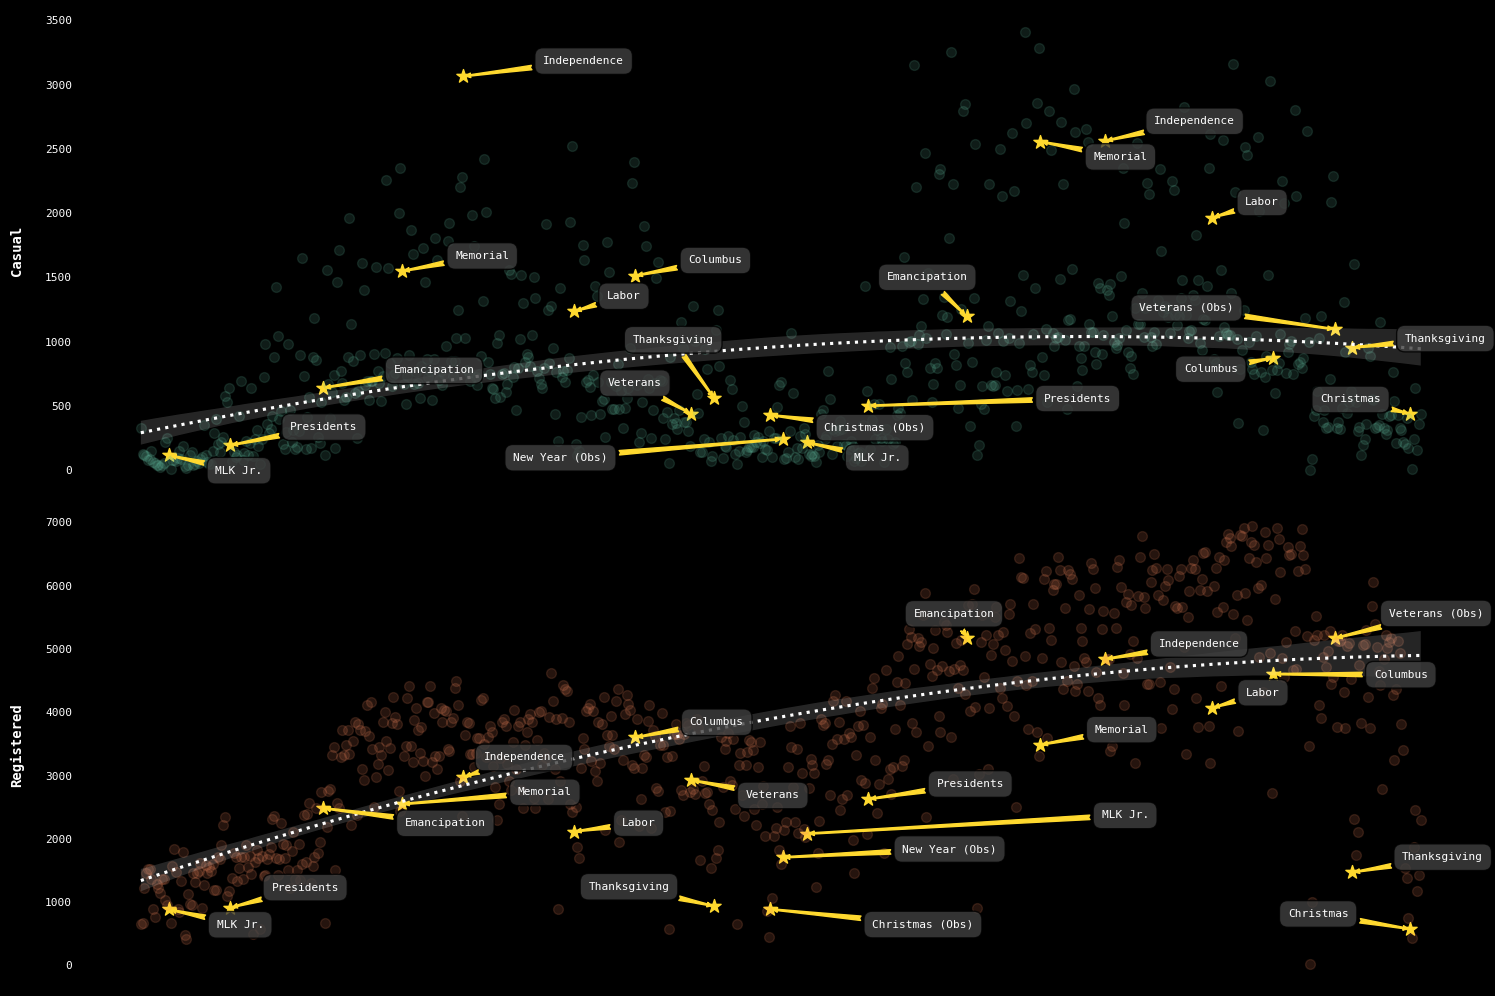

In [12]:
# 10. Do bike rentals increase on holidays due to an increase in casual users or registered users? 

def holiday_rental_subplots(df: pd.DataFrame):
    '''
    Visualizes the daily bike rentals for casual and registered users, with a focus on holidays.

    1. Aggregates data by `ordinal` to get daily sums.
    2. Creates two subplots: one for casual users and one for registered users.
    3. Plots scatter plots for each user type:
       - Holidays are highlighted with a distinct color, larger size, and star-shaped markers.
       - Non-holidays are shown with standard markers and reduced opacity.
    4. Labels the holidays with their respective names using annotations.
    5. Overlays a second-degree regression line on each subplot to visualize trends over time.

    Parameters:
        df (pd.DataFrame) : The bike sharing dataset as a pandas DataFrame.

    This function helps visualize the trend in bike rentals and the potential influence of holidays on demand. It 
    highlights any differences in behavior between casual and registered users. Such visual insights are valuable for 
    stakeholders aiming to optimize services around holidays and understand user behavior.
    '''

    _, ax    = plt.subplots(2, 1, sharex = True)
    g        = df.groupby('ordinal').agg({'casual': 'sum', 'registered': 'sum', 'holiday': 'max'}).reset_index()
    holidays = {734154: 'MLK Jr.',           734189: 'Presidents',       734242: 'Emancipation',
                734287: 'Memorial',          734322: 'Independence',     734385: 'Labor',
                734420: 'Columbus',          734452: 'Veterans',         734465: 'Thanksgiving',
                734497: 'Christmas (Obs)',   734504: 'New Year (Obs)',   734518: 'MLK Jr.',
                734553: 'Presidents',        734609: 'Emancipation',     734651: 'Memorial',
                734688: 'Independence',      734749: 'Labor',            734784: 'Columbus',
                734819: 'Veterans (Obs)',    734829: 'Thanksgiving',     734862: 'Christmas'}

    for i, user in enumerate(['casual', 'registered']):

        ax[i].scatter(g[g['holiday']]['ordinal'], 
                      g[g['holiday']][user], 
                      color  = colors[5],
                      s      = 100,
                      marker = '*',
                      alpha  = 1)
        
        ax[i].scatter(g[~g['holiday']]['ordinal'], 
                      g[~g['holiday']][user], 
                      color  = colors[i],
                      s      = 50,
                      marker = 'o',
                      alpha  = 0.15)

        adjust_text([ax[i].text(row['ordinal'], row[user], holidays.get(row['ordinal']), 
                                bbox = dict(facecolor = '0.25', 
                                            alpha     = 0.8, 
                                            boxstyle  = 'round, pad = 0.75')) for _, row in g[g['holiday']].iterrows()], 
                    ax            = ax[i], 
                    expand_points = (3,  3), 
                    expand_text   = (3,  3),
                    force_points  = (.1, .1),
                    arrowprops    = dict(arrowstyle = "fancy", color = colors[5]))

        sns.regplot(data     = g, 
                    x        = g['ordinal'], 
                    y        = user, 
                    ax       = ax[i], 
                    scatter  = False, 
                    order    = 2,
                    line_kws = {'color' : '1', 'linestyle' : ':'})
        
        ax[i].set_ylabel(user.capitalize())
        ax[i].xaxis.set_visible(False)

holiday_rental_subplots(bike_sharing)

### <span style="color:#0693e3">**Analysis on Question 10**</span>
Our aim for this analysis is to discern the patterns and behaviors associated with bike rentals on holidays as compared to regular days. We've divided the users into two categories: casual and registered users, to analyze their responses differently.

<span style="color:#0693e3">**Overall Rental Statistics**</span>  
- **Casual Users**: On non-holidays, the sum of bike rentals is 597,658 with an average of 842 rentals per day. On holidays, although the total rentals are 22,359, the average rentals per holiday is higher at 1,065, suggesting a spike in demand.
  
- **Registered Users**: On non-holidays, there are a total of 2,616,586 rentals, averaging 3,685 rentals daily. On holidays, the total rentals are 56,076, averaging 2,670 rentals per holiday.  

<span style="color:#0693e3">**Observations & Trends**</span>  
- Casual users display a marked increase in rentals on holidays as compared to average rentals on non-holidays, suggesting that holidays might be seen as opportunities for leisurely activities, leading to more casual users opting for bike rentals.

- Registered users, conversely, show a decrease in average rentals on holidays compared to regular days. This reinforced our previous findings that registered users primarily using the service for commuting.

- **Independence Day of 2011** in particular stands out for **casual** users with the highest holiday rental total of 3,065 bikes, a significant increase from the surrounding days.

<span style="color:#0693e3">**Implications & Recommendations**</span>  
It's evident that holidays play a significant role in altering rental patterns. For business strategya prospective rental company could promotional activities targeting casual users around holidays, as they are more likely to rent, and ensure availability and quality service during those high-demand holidays like Independence Day.

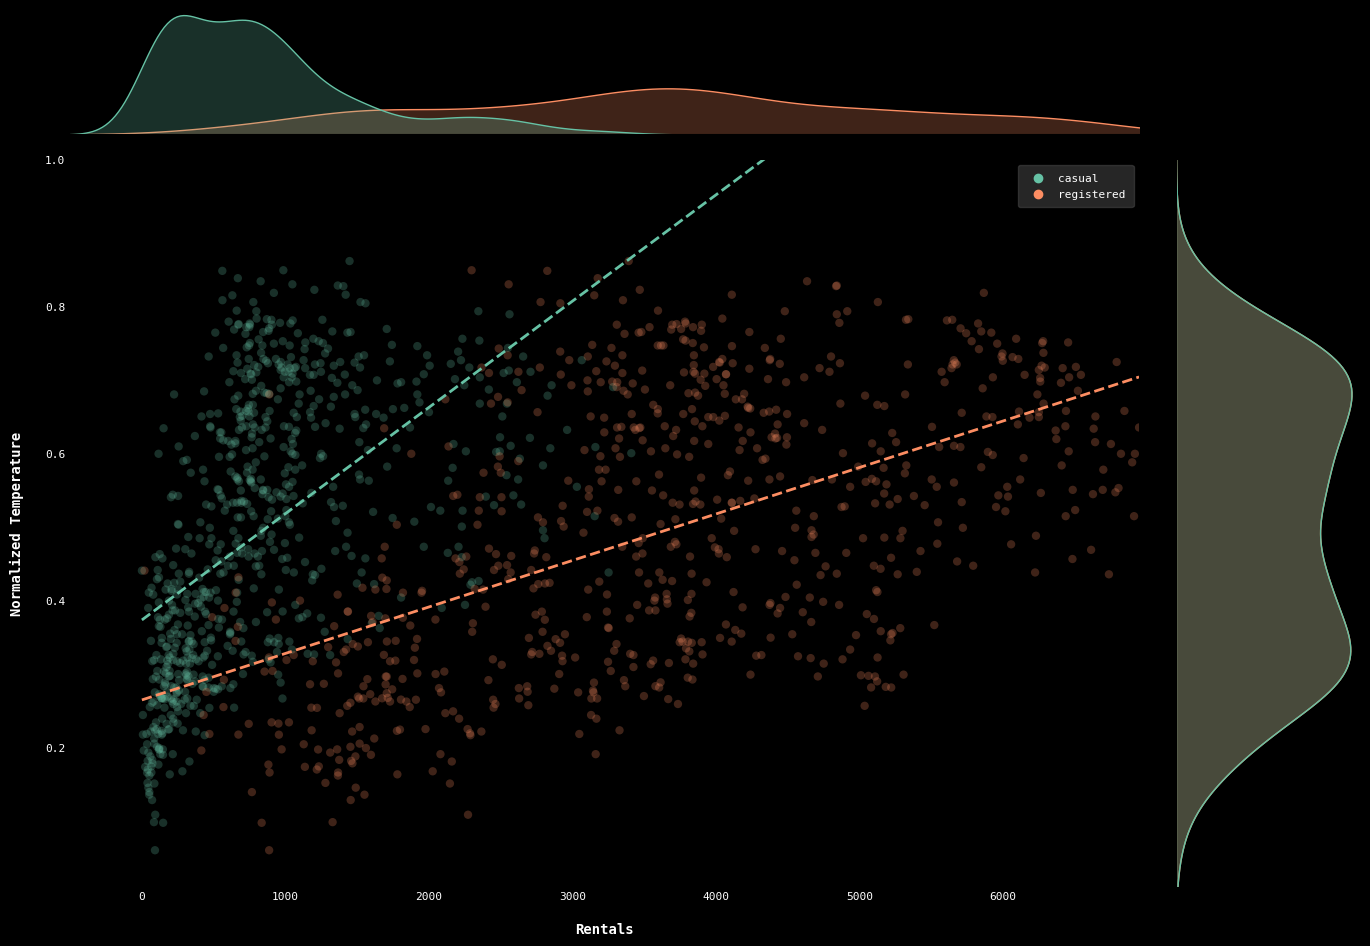

In [13]:
# 11. How does temperature correlate with the number of bike rentals?

def jointplot_temperature_rentals(df: pd.DataFrame):
    '''
    Visualizes the correlation between normalized temperature and bike rentals for casual and registered users.

    1. Aggregates data by `ordinal` to compute daily total rentals for both user types and the mean temperature.
    2. Melts the aggregated dataframe to have `type` (casual or registered) and `Rentals` columns.
    3. Creates a joint scatter plot with different colors for each user `type`
    4. Calculates and overlays a linear regression line for each user type to show the trend between temperature and rentals.
    5. Sets plot aesthetics like axis limits, legend, and figure size for better clarity.
    
    Parameters:
        df (pd.DataFrame) : The bike sharing dataset as a pandas DataFrame.

    This function visualizes the relationship between temperature and bike rentals, making distinctions between casual 
    and registered users. The insights drawn from this can be vital for demand forecasting, especially when considering 
    seasonality and temperature effects on bike rental patterns.
    '''
    
    melted = df.groupby('ordinal').agg({'casual': 'sum', 'registered': 'sum', 'temp': 'mean'}).reset_index() \
               .melt(id_vars    = ['ordinal', 'temp'], 
                     value_vars = ['casual', 'registered'], 
                     var_name   = 'type', 
                     value_name = 'Rentals')
    
    jp = sns.jointplot(x         = 'Rentals', 
                       y         = 'temp', 
                       hue       = 'type',
                       data      = melted,
                       joint_kws = {'edgecolor' : 'none', 'alpha' : 0.25})
    
    for type, color in zip(['casual', 'registered'], colors[:2]):

        m, b = np.polyfit(melted['Rentals'][melted['type'] == type], melted['temp'][melted['type'] == type], 1)
        x    = np.linspace(melted['Rentals'].min(), melted['Rentals'].max(), 100)
        
        jp.ax_joint.plot(x, m * x + b, 
                         color = color, linestyle = '--', linewidth = 2)

    jp.ax_joint.set_xlim(melted['Rentals'].min() - 500, melted['Rentals'].max())
    jp.ax_joint.set_ylim(0.01, 1)
    jp.fig.set_figheight(10)
    jp.fig.set_figwidth(15)
    plt.ylabel('Normalized Temperature')
    plt.legend()

jointplot_temperature_rentals(bike_sharing)

### <span style="color:#0693e3">**Analysis for Question 11**</span>
The objective of this analysis is to determine the relationship between temperature and the number of bike rentals, distinguishing between casual and registered users. By grasping this correlation, we can better forecast demand based on temperature predictions.

<span style="color:#0693e3">**Correlation & Linear Fit**</span>  
The linear fits for casual and registered users, represented by slope and intercept values, provide insight into the trend of rentals with respect to temperature changes. For casual users, with every unit increase in rentals, there's a **0.000145** increase in normalized temperature. In contrast, registered users exhibit a subtler change of **0.000063**. Both user categories show a positive correlation with temperature: casual users at **0.5433** and registered users at **0.5400**, suggesting that as temperatures rise, rentals increase for both groups.

<span style="color:#0693e3">**Implications for Demand Forecasting**</span>  
The close correlation values for both user groups indicate that temperature has a fairly similar influence on rental behaviors between casual and registered users. Understanding this positive correlation is invaluable for demand forecasting. As temperature predictions for future dates become available, the bike rental service can anticipate higher demands during warmer periods and adjust resources accordingly. Additionally, this insight reinforces our suggestions for both short-term operational decisions, such as bike maintenance scheduling, and long-term strategic decisions, such as promotional campaigns targeting casual users during warmer months.

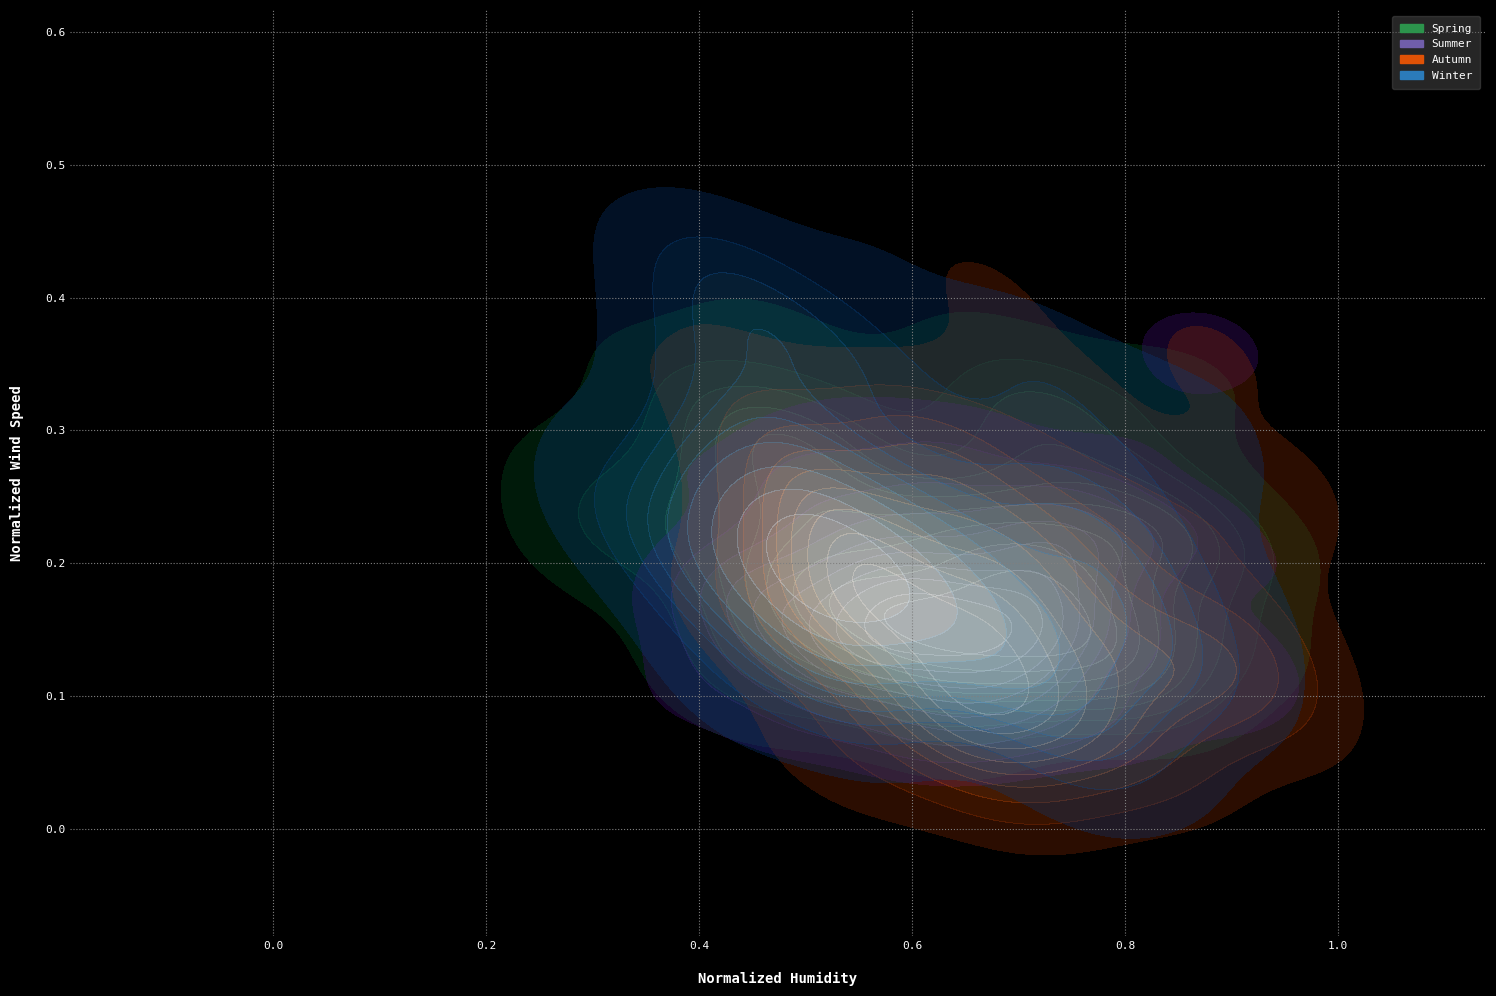

In [46]:
# 12. How does the combination of humidity and wind speed affect bike rentals across different seasons?

def kdeplot_humidity_windspeed(df: pd.DataFrame):
    '''
    Visualizes the relationship between humidity, wind speed, and bike rentals across different seasons.

    Functionality:
    1. Aggregates data by day to derive daily total rentals and average values for humidity and wind speed.
    2. Depicts a Kernel Density Estimate (KDE) for each season:
       - X-axis : Normalized Humidity
       - Y-axis : Normalized Wind Speed
       - Hue    : Distinguished using different colormaps for each season (winter, spring, summer, fall) 
                  to enhance interpretability.
    3. Displays a custom legend highlighting the color representation for each season.

    Parameters:
        df (pd.DataFrame) : The bike sharing dataset as a pandas DataFrame.

    This function provides insights into the combined effect of humidity and wind speed on bike rentals across 
    different seasons. The dedicated colormaps for each season, and the inclusion of a custom legend, help 
    readers rapidly discern the relationship across seasons. It can aid stakeholders in predicting rental demand 
    under varying weather conditions, especially if such conditions are expected during a specific season.
    '''

    daily_data = df.groupby(['ordinal', 'season']).agg({'hum'       : 'mean',
                                                        'windspeed' : 'mean',
                                                        'cnt'       : 'sum'}).reset_index()

    colors = {1: ['Spring', 'Greens_r'], 
              2: ['Summer', 'Purples_r'], 
              3: ['Autumn', 'Oranges_r'], 
              4: ['Winter', 'Blues_r']}

    for i, cm in enumerate(['Greens_r', 'Purples_r', 'Oranges_r', 'Blues_r']):
        subset = daily_data[daily_data['season'] == i + 1]
        sns.kdeplot(x     = subset['hum'], 
                    y     = subset['windspeed'], 
                    cmap  = cm, 
                    fill  = True, 
                    alpha = 0.3)

    plt.xlabel('Normalized Humidity')
    plt.ylabel('Normalized Wind Speed')
    plt.grid(True)
    plt.legend(handles = [pch.Patch(color = sns.color_palette(cm)[1], 
                                    label = season) for cm, season in zip(['Greens_r', 'Purples_r', 'Oranges_r', 'Blues_r'], 
                                                                          ['Spring',   'Summer',    'Autumn',    'Winter'])])

kdeplot_humidity_windspeed(bike_sharing)

### <span style="color:#0693e3">**Analysis for Question 12**</span> 
Across all bike sharing data, the average humidity stands at **62.79%** and wind speed at **0.1904 (normalized)**. When broken down by season:

1. **Spring (Season 1)** has an average bike rental count of **4,991**, with a notable maximum of **8,362** on a day when the humidity was around **69.42%** and wind speed was relatively low at **0.1163 (normalized)**.
   
2. **Summer (Season 2)** exhibits the highest average bike rentals at **5,623**, peaking at **8,714** rentals on a day with **50.17%** humidity and a slightly elevated wind speed of **0.2475 (normalized)**.
   
3. **Autumn (Season 3)** has an average count of **4,771** rentals, with the highest being **8,555** on a day characterized by **54.29%** humidity and wind speed of **0.2276 (normalized)**.
   
4. **Winter (Season 4)**, perhaps unsurprisingly, has the lowest average of **2,593** rentals. The peak rental day reached **7,836** with a considerably high humidity of **75.58%** and a low wind speed of **0.1107 (normalized)**.

<span style="color:#0693e3">**Correlation Insights**</span>  
Humidity and bike rentals have a slight negative correlation of **-0.1007**, suggesting a subtle trend where rentals decrease with increasing humidity. Wind speed shows a stronger negative correlation with rentals at **-0.2345**.

<span style="color:#0693e3">**Strategic Implications**</span>  
The correlations, though not particularly strong, indicate that on days with lower wind speeds and moderate humidity, a higher demand for bike rentals can be anticipated, which is especially true during spring and summer. Notably, winter emerges as a lucrative season for promotions or campaigns targeting increased usage.

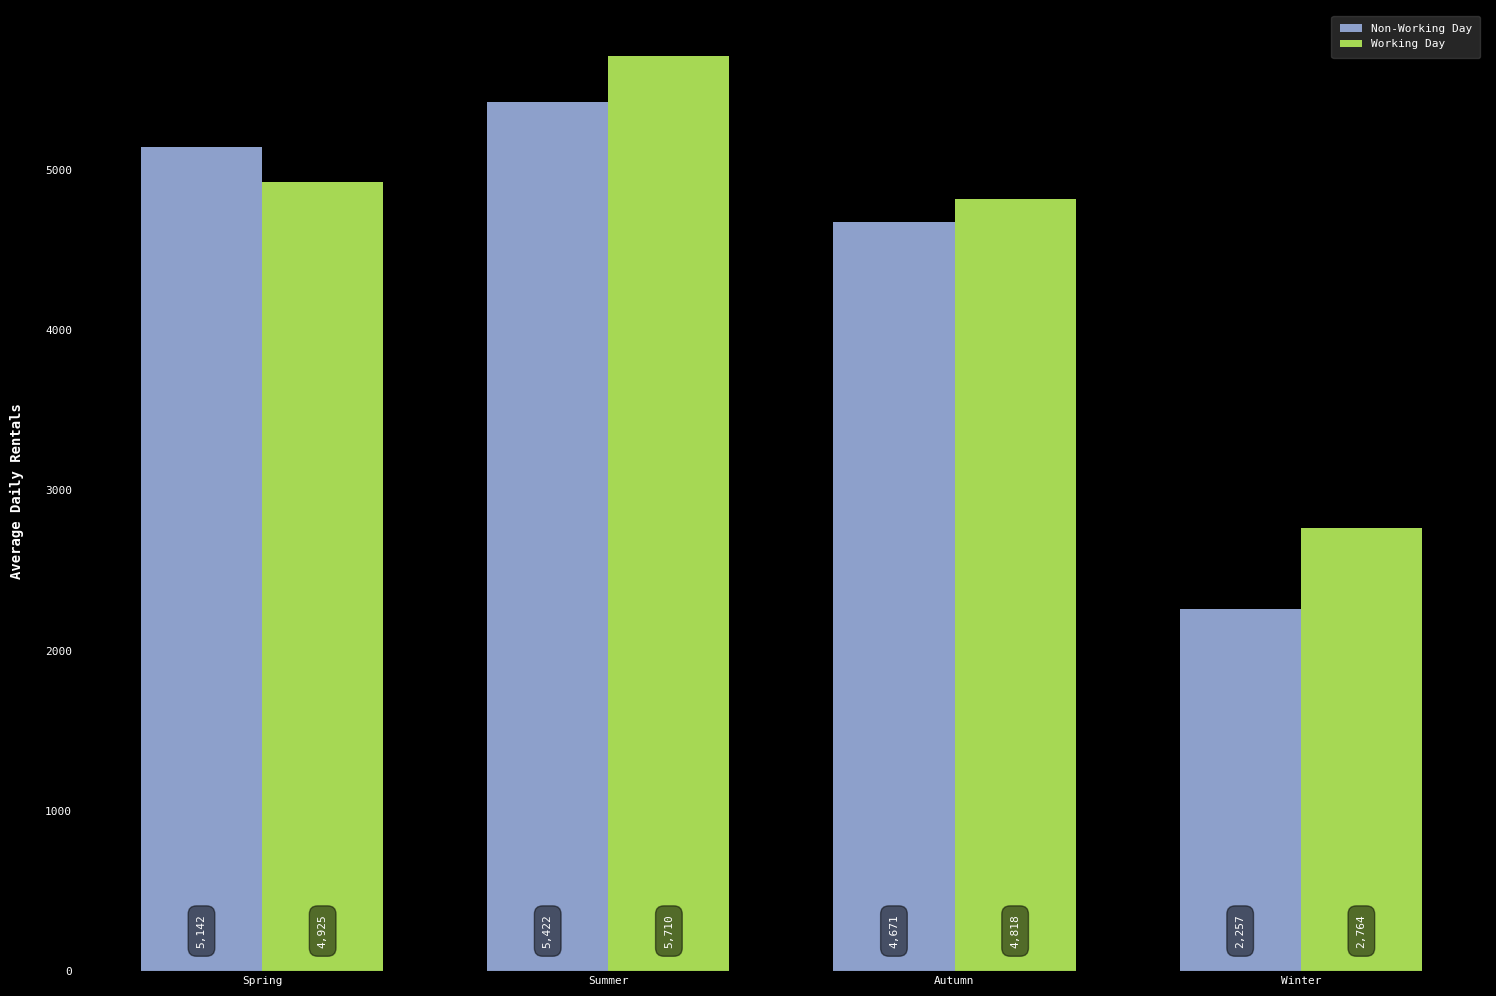

In [86]:
# 13. How does a working day versus a non-working day impact bike rentals across different seasons?

def workingday_bars(df: pd.DataFrame):
    '''
    Visualizes the impact of working days and non-working days on the number of bike rentals across different seasons using side-by-side bars.

    1. Maps the `season` column to corresponding season names.
    2. Groups the data by `season`, `workingday`, and `dteday` to compute the daily sum of bike rentals.
    3. Groups again by `season` and `workingday` to compute the daily average of bike rentals.
    4. Uses plt.bar to create side-by-side bars showing each season's average daily rentals for working days and non-working days.

    Parameters:
        df (pd.DataFrame) : The bike sharing dataset as a pandas DataFrame.
    '''

    g = df.groupby(['season', 'workingday', 'dteday'])['cnt'].sum().reset_index() \
          .groupby(['season', 'workingday'])['cnt'].mean().reset_index()

    seasons   = ['Spring', 'Summer', 'Autumn', 'Winter']
    bar_w     = 0.35
    color_map = {0: colors[2], 1: colors[4]}
    label_map = {0: 'Non-Working Day', 1: 'Working Day'}

    for i in range(2):
        bars = plt.bar(np.arange(4) + (i - 0.5) * bar_w, 
                    g[g['workingday'] == i]['cnt'], 
                    color = color_map[i], 
                    width = bar_w, 
                    label = label_map[i])
        
        for bar in bars:
            plt.text(bar.get_x() + bar.get_width() / 2, 250, 
                    f'{int(bar.get_height()):,}', 
                    va = 'center', ha = 'center', rotation = 90, 
                    bbox = dict(facecolor = '0', alpha = 0.5, boxstyle='round, pad = 0.75'))

    plt.xticks(np.arange(4), seasons)
    plt.ylabel('Average Daily Rentals')
    plt.legend()

workingday_bars(bike_sharing)

### <span style="color:#0693e3">**Analysis for Question 13**</span> 

While there are slight differences in the totals for working days and non-working days across each season, the daily averages are generally consistent. Overall, bike rentals are slightly higher on working days compared to non-working days, except for Spring where the pattern is reversed. 

As expected, summer exhibits the highest demand for bike rentals, irrespective of whether it's a working day or not. Conversely, Winter witnesses the lowest demand, but the gap between rentals on working and non-working days is most pronounced during this season.

<span style="color:#0693e3">**Strategic Implications**</span>  
Bike sharing services should anticipate higher demands during Summer, especially on working days. Tailored promotions targeting non-working days during Winter could help in bridging the gap observed during this season. Spring presents a unique scenario where non-working day promotions might be beneficial given the existing trend.

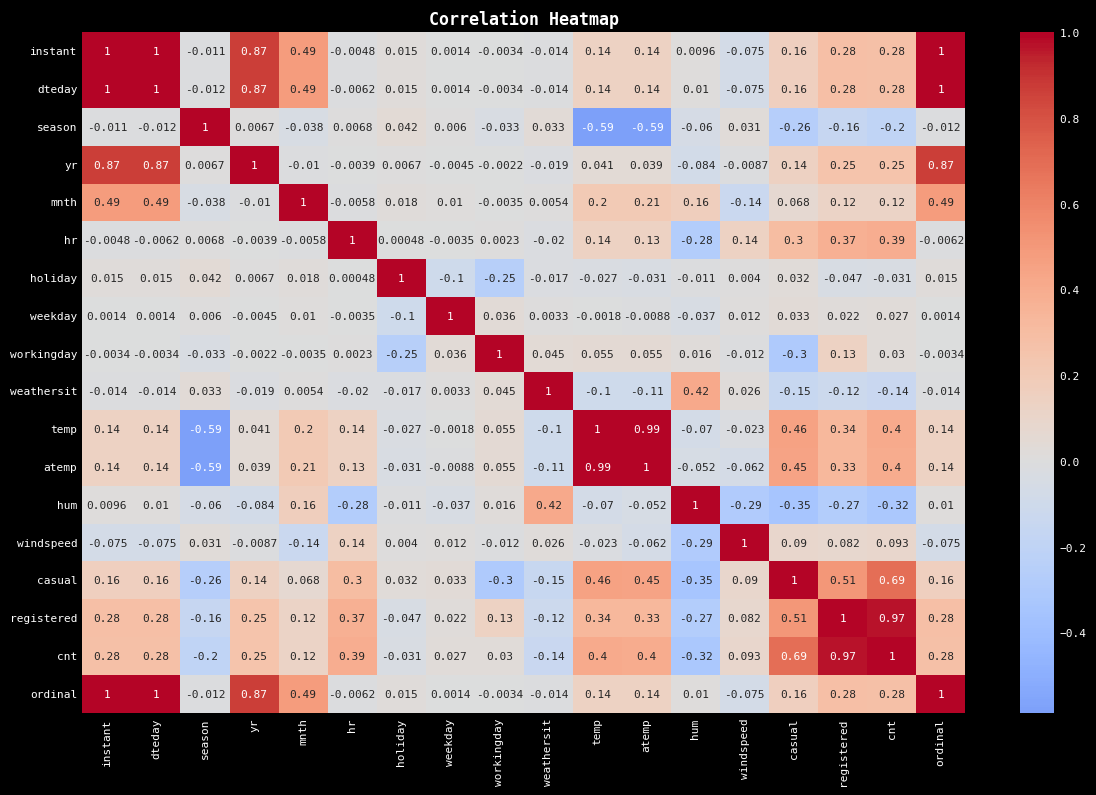

In [15]:
# 18. Are there any other correlations within the numeric columns in the dataset we might be overlooking?

import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df: pd.DataFrame):
    correlation_matrix = df.corr()  # Compute pairwise correlation of columns
    plt.figure(figsize=(12, 8))
    
    # Plot the heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title("Correlation Heatmap")

plot_correlation_heatmap(bike_sharing)